In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydicom import read_file
import re

PROJ_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"

JOINT_PATH = os.path.join(PROJ_DIR, "joint_export/dwh_tables")

EXPORT_1 = os.path.join(PROJ_DIR, "dwh_tables")
EXPORT_2 = os.path.join(PROJ_DIR, "Studies2_202012/dwh_tables")

OCT_DIR_EXPORT_1 = os.path.join(PROJ_DIR, "Studies/Optical Coherence Tomography Scanner")
OCT_DIR_EXPORT_2 = os.path.join(PROJ_DIR, "Studies2_202012/OPT")

DIR_EXPORT_1 = os.path.join(PROJ_DIR, "Studies")
DIR_EXPORT_2 = os.path.join(PROJ_DIR, "Studies2_202012")

## Join OCT meta tables from both exports

In [2]:
oct_meta_export_1 = os.path.join(DIR_EXPORT_1, 'oct_meta_information.csv')
oct_meta_export_2 = os.path.join(DIR_EXPORT_2, 'oct_meta_information.csv')

oct_meta_export_1_pd = pd.read_csv(oct_meta_export_1)
oct_meta_export_2_pd = pd.read_csv(oct_meta_export_2)

#### pre process tables

In [3]:
oct_meta_export_1_pd["PATNR"] = oct_meta_export_1_pd.PATNR.str.replace("ps:", "")
oct_meta_export_1_pd = oct_meta_export_1_pd.drop(columns={"Unnamed: 0"})

oct_meta_export_2_pd = oct_meta_export_2_pd.drop(columns={"Unnamed: 0"})

In [4]:
oct_meta_export_1_pd.head()

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits
0,363979,R,20180129,19900101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",31,2
1,363979,L,20180129,19900101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",31,2
2,350569,R,20170306,20110101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",10,2
3,350569,L,20170306,20110101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",10,2
4,185669,L,20141209,19720101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",49,2


In [5]:
oct_meta_export_2_pd.head()

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits
0,381934,R,20200513,19450901,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",75,2
1,381934,L,20200513,19450901,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",75,2
2,9846,L,20181219,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17
3,9846,L,20181009,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17
4,9846,L,20190213,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17


#### Filter DICOMS of right type and img shape

In [6]:
export2_study_descr_bool = oct_meta_export_2_pd.study_description == 'Makula (OCT)'
export2_img_shape_bool = oct_meta_export_2_pd.img_shape == '(49, 496, 512)'

print("Number of DICOMS before filtering: ", oct_meta_export_2_pd.shape[0])

oct_meta_export_2_pd = oct_meta_export_2_pd[export2_study_descr_bool & export2_img_shape_bool]

print("Number of DICOMS after filtering: ", oct_meta_export_2_pd.shape[0])

Number of DICOMS before filtering:  244533
Number of DICOMS after filtering:  165371


In [7]:
export1_study_descr_bool = oct_meta_export_1_pd.study_description == 'Makula (OCT)'
export1_img_shape_bool = oct_meta_export_1_pd.img_shape == '(49, 496, 512)'

print("Number of DICOMS before filtering: ", oct_meta_export_1_pd.shape[0])

oct_meta_export_1_pd = oct_meta_export_1_pd[export1_study_descr_bool & export1_img_shape_bool]

print("Number of DICOMS after filtering: ", oct_meta_export_1_pd.shape[0])

Number of DICOMS before filtering:  171100
Number of DICOMS after filtering:  136302


### Append meta tables and drop duplicates

In [8]:
print(f"Number of OCT studies from export 1: {oct_meta_export_1_pd.shape[0]} \
      and export 2: {oct_meta_export_2_pd.shape[0]}")

# assign column stating export
oct_meta_export_1_pd["export"] = "1"
oct_meta_export_2_pd["export"] = "2"

joint_meta_pd = oct_meta_export_1_pd.append(oct_meta_export_2_pd)

print("Number of records bef drop: ", joint_meta_pd.shape[0])

joint_meta_pd = joint_meta_pd.drop_duplicates(subset=joint_meta_pd.columns)

print("Number of records after drop: ", joint_meta_pd.shape[0])

print(f"Number of added OCTs from second export: {joint_meta_pd.shape[0] - oct_meta_export_1_pd.shape[0]}")

Number of OCT studies from export 1: 136302       and export 2: 165371
Number of records bef drop:  301673
Number of records after drop:  290616
Number of added OCTs from second export: 154314


#### Add dicom path to each OCT record

In [9]:
joint_export_dicom_paths = pd.read_csv(os.path.join(PROJ_DIR, "joint_export/dicom_paths.csv"))
path_info = joint_export_dicom_paths["0"].str.split("/", expand=True)[[9, 10, 11, 12]]

# add export info
path_info["export"] = joint_export_dicom_paths["0"].str.split("/", expand=True)[7]

# convert laterality format
path_info[10] = path_info[10].str.replace("Left", "L").str.replace("Right", "R")

joint_meta_pd["study_date"] = joint_meta_pd["study_date"].astype(str)
joint_meta_pd["PATNR"] = joint_meta_pd.PATNR.astype(str)

In [11]:
joint_meta_export_1_pd = joint_meta_pd[joint_meta_pd.export=="1"]
joint_meta_export_2_pd = joint_meta_pd[joint_meta_pd.export=="2"]

In [19]:
joint_meta_exp_1_pd = pd.merge(joint_meta_export_1_pd, path_info[path_info.export=="Studies"], 
                         left_on=["PATNR", "laterality", "study_date"], 
                         right_on=[9, 10, 11], how="left")

joint_meta_exp_2_pd = pd.merge(joint_meta_export_2_pd, path_info[path_info.export=="Studies2_202012"], 
                         left_on=["PATNR", "laterality", "study_date"], 
                         right_on=[9, 10, 11], how="left")

#### drop, rename thus align columns for appending

In [20]:
joint_meta_exp_1_pd.drop(columns=[9, 10, 11, "export_y"], inplace=True)
joint_meta_exp_1_pd.rename(columns={"export_x": "export", 12: "dicom_name"}, inplace=True)

In [21]:
joint_meta_exp_2_pd.drop(columns=[9, 10, 11, "export_y"], inplace=True)
joint_meta_exp_2_pd.rename(columns={"export_x": "export", 12: "dicom_name"}, inplace=True)

In [22]:
joint_meta_exp_2_pd.head()

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name
0,381934,R,20200513,19450901,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",75,2,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1323383288...
1,381934,L,20200513,19450901,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",75,2,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1323383288...
2,9846,L,20181219,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1318968422...
3,9846,L,20181009,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17,2,OPt.1.3.6.1.4.1.33437.10.4.6339912.13183544275...
4,9846,L,20190213,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17,2,OPt.1.3.6.1.4.1.33437.10.4.6339912.13194535929...


#### Create correct laterality string for export 2 path

In [23]:
lat_exp1 = joint_meta_exp_1_pd["laterality"].copy()

lat_exp1[lat_exp1 == "R"]  = lat_exp1[lat_exp1 == "R"] + "ight"
lat_exp1[lat_exp1 == "L"]  = lat_exp1[lat_exp1 == "L"] + "eft"

In [24]:
PATH_EXT_1 = joint_meta_exp_1_pd.PATNR + "/" + lat_exp1 + "/" + joint_meta_exp_1_pd.study_date
PATH_EXT_2 = joint_meta_exp_2_pd.PATNR + "/" + joint_meta_exp_2_pd.laterality + "/" + joint_meta_exp_2_pd.study_date

joint_meta_exp_1_pd["oct_path"] = OCT_DIR_EXPORT_1 + "/" + PATH_EXT_1 + "/" + joint_meta_exp_1_pd.dicom_name
joint_meta_exp_2_pd["oct_path"] = OCT_DIR_EXPORT_2 + "/" + PATH_EXT_2 + "/" + joint_meta_exp_2_pd.dicom_name

In [25]:
joint_meta_pd = joint_meta_exp_1_pd.append(joint_meta_exp_2_pd)

#### Save joint meta table to joint export directory

In [26]:
joint_meta_pd.to_csv(os.path.join(PROJ_DIR, "joint_export", "oct_meta_information.csv"), index=False)

In [27]:
joint_meta_pd.head()

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path
0,363979,R,20180129,19900101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",31,2,1,1.3.6.1.4.1.33437.10.4.4089432.13161688882.283...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
1,363979,L,20180129,19900101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",31,2,1,1.3.6.1.4.1.33437.10.4.4089432.13161688884.283...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
2,350569,R,20170306,20110101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",10,2,1,1.3.6.1.4.1.33437.10.4.4089432.13133269474.269...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
3,350569,L,20170306,20110101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",10,2,1,1.3.6.1.4.1.33437.10.4.4089432.13133269479.269...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
4,185669,L,20141209,19720101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",49,2,1,1.3.6.1.4.1.33437.10.4.15740454.13062592861.12...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...


### Join Diagnosen and Prozeduren tables

In [28]:
print("Files in joint path", os.listdir(JOINT_PATH))

joint_prozeduren_pd = pd.read_csv(os.path.join(JOINT_PATH, 'prozeduren.csv'))
joint_diagnosis_pd = pd.read_csv(os.path.join(JOINT_PATH, 'diagnosis.csv'))

Files in joint path ['prozeduren.csv', 'tensio.csv', 'visus_labels.csv', 'diagnosis.csv']


In [29]:
joint_prozeduren_pd.head()

,Unnamed: 0,DAT,ICPMK,ICPML,LOK,PATNR
0,0,2006-03-15 00:00:00,P4,5-984,L,17
1,1,2014-05-21 00:00:00,PC,5-091.10,L,17
2,2,2015-02-10 00:00:00,PD,5-984,NaN,17
3,3,2015-07-13 00:00:00,PD,3-300.0,NaN,17
4,4,2018-01-08 00:00:00,PG,5-156.9,R,18


In [30]:
joint_diagnosis_pd.head()

,Unnamed: 0,DAT,DKAT,DKEY,LOK,PATNR
0,0,2003-11-18 00:00:00,A1,C44.18,NaN,17
1,1,2006-03-15 00:00:00,4,J45.9,NaN,17
2,2,2006-03-15 00:00:00,AS,ASA1,NaN,17
3,3,2006-11-07 00:00:00,4,C44.1,NaN,17
4,4,2007-08-07 00:00:00,5,C44.1,NaN,17


#### remove nan values from patient id

In [31]:
joint_meta_pd = joint_meta_pd[joint_meta_pd["PATNR"] != "nan"]

### Get list of unique diagnosises for each patient

In [32]:
unique_patients = joint_meta_pd["PATNR"].drop_duplicates().tolist()

joint_diagnosis_pd["DAT_dt"] = pd.to_datetime(joint_diagnosis_pd.DAT)

diagnosis_dict = {"PATNR": [], "AMD": [], "DKEY_first_date": []}

for patient in tqdm(unique_patients):
    diagnosis_dict["PATNR"].append(patient)
    
    patient_dkat_pd = joint_diagnosis_pd[joint_diagnosis_pd.PATNR == int(patient)]
    dkeys = patient_dkat_pd.DKEY.drop_duplicates().values
    
    if any("H35.3" in str(dk) for dk in dkeys):
        amd_dates = patient_dkat_pd[patient_dkat_pd.DKEY.str.contains('H35.3').fillna(False)].DAT_dt
        
        diagnosis_dict["DKEY_first_date"].append(min(amd_dates))
        diagnosis_dict["AMD"].append(True)
    else:
        diagnosis_dict["DKEY_first_date"].append(np.nan)
        diagnosis_dict["AMD"].append(False)

  0%|          | 11/34062 [00:00<05:16, 107.72it/s]

  0%|          | 43/34062 [00:00<04:28, 126.63it/s]

  0%|          | 65/34062 [00:00<04:58, 113.76it/s]

  0%|          | 87/34062 [00:00<05:09, 109.62it/s]

  0%|          | 116/34062 [00:00<04:33, 124.10it/s]

  0%|          | 150/34062 [00:01<03:59, 141.43it/s]

  1%|          | 184/34062 [00:01<03:42, 152.36it/s]

  1%|          | 216/34062 [00:01<03:41, 152.80it/s]

  1%|          | 248/34062 [00:01<03:40, 153.27it/s]

  1%|          | 281/34062 [00:01<03:36, 155.76it/s]

  1%|          | 313/34062 [00:02<03:36, 155.88it/s]

  1%|          | 345/34062 [00:02<03:36, 155.75it/s]

  1%|          | 378/34062 [00:02<03:34, 156.84it/s]

  1%|          | 410/34062 [00:02<03:35, 155.93it/s]

  1%|▏         | 442/34062 [00:03<03:37, 154.42it/s]

  1%|▏         | 475/34062 [00:03<03:36, 155.27it/s]

  1%|▏         | 509/34062 [00:03<03:31, 158.85it/s]

  2%|▏         | 542/34062 [00:03<03:31, 158.75it/s]

  2%|▏         | 574/34062 [00:03<03:32, 157.55it/s]

  2%|▏         | 608/34062 [00:04<03:29, 159.47it/s]

  2%|▏         | 640/34062 [00:04<03:32, 157.39it/s]

  2%|▏         | 674/34062 [00:04<03:29, 159.59it/s]

  2%|▏         | 706/34062 [00:04<03:31, 158.03it/s]

  2%|▏         | 739/34062 [00:04<03:30, 158.59it/s]

  2%|▏         | 771/34062 [00:05<03:33, 155.58it/s]

  2%|▏         | 803/34062 [00:05<03:33, 155.80it/s]

  2%|▏         | 837/34062 [00:05<03:29, 158.88it/s]

  3%|▎         | 869/34062 [00:05<03:33, 155.38it/s]

  3%|▎         | 903/34062 [00:05<03:27, 159.73it/s]

  3%|▎         | 936/34062 [00:06<03:28, 158.78it/s]

  3%|▎         | 968/34062 [00:06<03:31, 156.43it/s]

  3%|▎         | 1000/34062 [00:06<03:31, 156.01it/s]

  3%|▎         | 1032/34062 [00:06<03:31, 156.21it/s]

  3%|▎         | 1064/34062 [00:06<03:30, 156.63it/s]

  3%|▎         | 1096/34062 [00:07<03:30, 156.91it/s]

  3%|▎         | 1128/34062 [00:07<03:31, 155.89it/s]

  3%|▎         | 1160/34062 [00:07<03:30, 156.61it/s]

  4%|▎         | 1193/34062 [00:07<03:26, 159.51it/s]

  4%|▎         | 1226/34062 [00:07<03:25, 159.55it/s]

  4%|▎         | 1260/34062 [00:08<03:24, 160.19it/s]

  4%|▍         | 1294/34062 [00:08<03:25, 159.24it/s]

  4%|▍         | 1326/34062 [00:08<03:27, 157.52it/s]

  4%|▍         | 1359/34062 [00:08<03:26, 158.00it/s]

  4%|▍         | 1392/34062 [00:09<03:24, 160.08it/s]

  4%|▍         | 1425/34062 [00:09<03:28, 156.58it/s]

  4%|▍         | 1458/34062 [00:09<03:26, 157.85it/s]

  4%|▍         | 1491/34062 [00:09<03:25, 158.71it/s]

  4%|▍         | 1524/34062 [00:09<03:24, 158.82it/s]

  5%|▍         | 1557/34062 [00:10<03:25, 158.32it/s]

  5%|▍         | 1590/34062 [00:10<03:25, 158.38it/s]

  5%|▍         | 1622/34062 [00:10<03:27, 156.52it/s]

  5%|▍         | 1654/34062 [00:10<03:29, 154.75it/s]

  5%|▍         | 1687/34062 [00:10<03:25, 157.24it/s]

  5%|▌         | 1720/34062 [00:11<03:24, 158.20it/s]

  5%|▌         | 1754/34062 [00:11<03:23, 158.70it/s]

  5%|▌         | 1786/34062 [00:11<03:25, 157.29it/s]

  5%|▌         | 1819/34062 [00:11<03:23, 158.70it/s]

  5%|▌         | 1852/34062 [00:11<03:23, 158.45it/s]

  6%|▌         | 1885/34062 [00:12<03:23, 157.93it/s]

  6%|▌         | 1918/34062 [00:12<03:23, 158.15it/s]

  6%|▌         | 1951/34062 [00:12<03:22, 158.87it/s]

  6%|▌         | 1985/34062 [00:12<03:23, 157.68it/s]

  6%|▌         | 2018/34062 [00:12<03:24, 156.69it/s]

  6%|▌         | 2051/34062 [00:13<03:22, 158.44it/s]

  6%|▌         | 2085/34062 [00:13<03:19, 160.01it/s]

  6%|▌         | 2119/34062 [00:13<03:21, 158.76it/s]

  6%|▋         | 2153/34062 [00:13<03:18, 160.74it/s]

  6%|▋         | 2187/34062 [00:14<03:18, 160.42it/s]

  7%|▋         | 2220/34062 [00:14<03:21, 157.66it/s]

  7%|▋         | 2252/34062 [00:14<03:23, 156.21it/s]

  7%|▋         | 2284/34062 [00:14<03:22, 156.66it/s]

  7%|▋         | 2317/34062 [00:14<03:21, 157.39it/s]

  7%|▋         | 2349/34062 [00:15<03:20, 157.79it/s]

  7%|▋         | 2381/34062 [00:15<03:23, 155.90it/s]

  7%|▋         | 2414/34062 [00:15<03:21, 157.05it/s]

  7%|▋         | 2446/34062 [00:15<03:21, 156.68it/s]

  7%|▋         | 2479/34062 [00:15<03:21, 156.59it/s]

  7%|▋         | 2512/34062 [00:16<03:20, 157.49it/s]

  7%|▋         | 2545/34062 [00:16<03:20, 157.17it/s]

  8%|▊         | 2577/34062 [00:16<03:21, 156.00it/s]

  8%|▊         | 2610/34062 [00:16<03:22, 155.49it/s]

  8%|▊         | 2642/34062 [00:16<03:21, 155.61it/s]

  8%|▊         | 2675/34062 [00:17<03:20, 156.32it/s]

  8%|▊         | 2691/34062 [00:17<03:23, 154.34it/s]

  8%|▊         | 2723/34062 [00:17<03:21, 155.64it/s]

  8%|▊         | 2756/34062 [00:17<03:19, 157.05it/s]

  8%|▊         | 2789/34062 [00:17<03:20, 156.26it/s]

  8%|▊         | 2821/34062 [00:18<03:19, 156.24it/s]

  8%|▊         | 2855/34062 [00:18<03:17, 157.82it/s]

  8%|▊         | 2887/34062 [00:18<03:19, 156.06it/s]

  9%|▊         | 2919/34062 [00:18<03:20, 155.60it/s]

  9%|▊         | 2952/34062 [00:18<03:18, 156.38it/s]

  9%|▉         | 2986/34062 [00:19<03:14, 159.61it/s]

  9%|▉         | 3020/34062 [00:19<03:14, 159.33it/s]

  9%|▉         | 3052/34062 [00:19<03:14, 159.26it/s]

  9%|▉         | 3085/34062 [00:19<03:13, 160.09it/s]

  9%|▉         | 3118/34062 [00:19<03:17, 156.71it/s]

  9%|▉         | 3151/34062 [00:20<03:13, 159.87it/s]

  9%|▉         | 3184/34062 [00:20<03:14, 158.85it/s]

  9%|▉         | 3218/34062 [00:20<03:13, 159.20it/s]

 10%|▉         | 3250/34062 [00:20<03:16, 157.14it/s]

 10%|▉         | 3283/34062 [00:21<03:14, 158.41it/s]

 10%|▉         | 3316/34062 [00:21<03:15, 157.40it/s]

 10%|▉         | 3349/34062 [00:21<03:14, 158.00it/s]

 10%|▉         | 3382/34062 [00:21<03:12, 159.25it/s]

 10%|█         | 3416/34062 [00:21<03:12, 159.20it/s]

 10%|█         | 3449/34062 [00:22<03:14, 157.76it/s]

 10%|█         | 3481/34062 [00:22<03:15, 156.10it/s]

 10%|█         | 3513/34062 [00:22<03:15, 156.53it/s]

 10%|█         | 3546/34062 [00:22<03:15, 155.76it/s]

 11%|█         | 3578/34062 [00:22<03:14, 156.93it/s]

 11%|█         | 3610/34062 [00:23<03:15, 155.56it/s]

 11%|█         | 3643/34062 [00:23<03:14, 156.31it/s]

 11%|█         | 3676/34062 [00:23<03:11, 158.94it/s]

 11%|█         | 3708/34062 [00:23<03:14, 156.32it/s]

 11%|█         | 3740/34062 [00:23<03:16, 154.08it/s]

 11%|█         | 3773/34062 [00:24<03:12, 157.02it/s]

 11%|█         | 3807/34062 [00:24<03:08, 160.32it/s]

 11%|█▏        | 3841/34062 [00:24<03:08, 160.51it/s]

 11%|█▏        | 3875/34062 [00:24<03:05, 162.66it/s]

 11%|█▏        | 3909/34062 [00:24<03:07, 160.59it/s]

 12%|█▏        | 3942/34062 [00:25<03:11, 157.59it/s]

 12%|█▏        | 3974/34062 [00:25<03:10, 157.96it/s]

 12%|█▏        | 4006/34062 [00:25<03:15, 153.70it/s]

 12%|█▏        | 4039/34062 [00:25<03:12, 156.05it/s]

 12%|█▏        | 4072/34062 [00:26<03:10, 157.39it/s]

 12%|█▏        | 4105/34062 [00:26<03:09, 158.36it/s]

 12%|█▏        | 4138/34062 [00:26<03:09, 157.65it/s]

 12%|█▏        | 4170/34062 [00:26<03:10, 156.71it/s]

 12%|█▏        | 4203/34062 [00:26<03:09, 157.65it/s]

 12%|█▏        | 4235/34062 [00:27<03:10, 156.98it/s]

 13%|█▎        | 4269/34062 [00:27<03:06, 159.64it/s]

 13%|█▎        | 4302/34062 [00:27<03:05, 160.04it/s]

 13%|█▎        | 4335/34062 [00:27<03:08, 158.00it/s]

 13%|█▎        | 4368/34062 [00:27<03:05, 159.95it/s]

 13%|█▎        | 4402/34062 [00:28<03:04, 160.64it/s]

 13%|█▎        | 4435/34062 [00:28<03:08, 157.30it/s]

 13%|█▎        | 4468/34062 [00:28<03:06, 158.33it/s]

 13%|█▎        | 4501/34062 [00:28<03:05, 159.11it/s]

 13%|█▎        | 4533/34062 [00:28<03:09, 155.80it/s]

 13%|█▎        | 4565/34062 [00:29<03:11, 154.05it/s]

 13%|█▎        | 4598/34062 [00:29<03:06, 158.19it/s]

 14%|█▎        | 4630/34062 [00:29<03:10, 154.24it/s]

 14%|█▎        | 4663/34062 [00:29<03:06, 157.91it/s]

 14%|█▍        | 4695/34062 [00:29<03:07, 156.25it/s]

 14%|█▍        | 4729/34062 [00:30<03:02, 161.14it/s]

 14%|█▍        | 4746/34062 [00:30<03:02, 160.21it/s]

 14%|█▍        | 4780/34062 [00:30<03:06, 157.29it/s]

 14%|█▍        | 4813/34062 [00:30<03:05, 157.98it/s]

 14%|█▍        | 4847/34062 [00:30<03:02, 160.49it/s]

 14%|█▍        | 4881/34062 [00:31<03:04, 158.22it/s]

 14%|█▍        | 4913/34062 [00:31<03:04, 158.24it/s]

 15%|█▍        | 4946/34062 [00:31<03:02, 159.16it/s]

 15%|█▍        | 4978/34062 [00:31<03:06, 156.14it/s]

 15%|█▍        | 5011/34062 [00:31<03:04, 157.47it/s]

 15%|█▍        | 5044/34062 [00:32<03:03, 157.86it/s]

 15%|█▍        | 5077/34062 [00:32<03:02, 158.93it/s]

 15%|█▌        | 5110/34062 [00:32<03:01, 159.46it/s]

 15%|█▌        | 5144/34062 [00:32<03:02, 158.76it/s]

 15%|█▌        | 5176/34062 [00:33<03:05, 155.65it/s]

 15%|█▌        | 5209/34062 [00:33<03:03, 156.90it/s]

 15%|█▌        | 5241/34062 [00:33<03:33, 134.69it/s]

 15%|█▌        | 5255/34062 [00:33<03:55, 122.47it/s]

 16%|█▌        | 5281/34062 [00:33<04:03, 118.42it/s]

 16%|█▌        | 5315/34062 [00:34<03:29, 137.15it/s]

 16%|█▌        | 5348/34062 [00:34<03:14, 147.38it/s]

 16%|█▌        | 5380/34062 [00:34<03:07, 152.63it/s]

 16%|█▌        | 5412/34062 [00:34<03:05, 154.53it/s]

 16%|█▌        | 5444/34062 [00:34<03:04, 155.18it/s]

 16%|█▌        | 5476/34062 [00:35<03:03, 156.16it/s]

 16%|█▌        | 5509/34062 [00:35<03:02, 156.86it/s]

 16%|█▋        | 5541/34062 [00:35<03:02, 156.14it/s]

 16%|█▋        | 5573/34062 [00:35<03:03, 155.07it/s]

 16%|█▋        | 5606/34062 [00:35<03:01, 156.62it/s]

 17%|█▋        | 5638/34062 [00:36<03:01, 156.61it/s]

 17%|█▋        | 5671/34062 [00:36<03:03, 154.55it/s]

 17%|█▋        | 5703/34062 [00:36<03:02, 155.12it/s]

 17%|█▋        | 5736/34062 [00:36<02:59, 157.59it/s]

 17%|█▋        | 5769/34062 [00:36<02:58, 158.90it/s]

 17%|█▋        | 5803/34062 [00:37<02:55, 160.74it/s]

 17%|█▋        | 5837/34062 [00:37<02:57, 159.03it/s]

 17%|█▋        | 5869/34062 [00:37<02:59, 157.00it/s]

 17%|█▋        | 5902/34062 [00:37<02:58, 157.77it/s]

 17%|█▋        | 5936/34062 [00:37<02:56, 159.22it/s]

 18%|█▊        | 5969/34062 [00:38<02:57, 158.51it/s]

 18%|█▊        | 6003/34062 [00:38<02:57, 157.71it/s]

 18%|█▊        | 6035/34062 [00:38<03:01, 154.24it/s]

 18%|█▊        | 6068/34062 [00:38<03:01, 154.33it/s]

 18%|█▊        | 6101/34062 [00:39<02:57, 157.20it/s]

 18%|█▊        | 6133/34062 [00:39<02:56, 158.02it/s]

 18%|█▊        | 6167/34062 [00:39<02:53, 161.13it/s]

 18%|█▊        | 6184/34062 [00:39<02:55, 158.68it/s]

 18%|█▊        | 6218/34062 [00:39<02:54, 159.98it/s]

 18%|█▊        | 6251/34062 [00:39<02:56, 158.00it/s]

 18%|█▊        | 6284/34062 [00:40<02:54, 158.82it/s]

 19%|█▊        | 6316/34062 [00:40<02:58, 155.15it/s]

 19%|█▊        | 6348/34062 [00:40<02:57, 155.80it/s]

 19%|█▊        | 6380/34062 [00:40<02:57, 155.59it/s]

 19%|█▉        | 6413/34062 [00:41<02:57, 156.10it/s]

 19%|█▉        | 6445/34062 [00:41<02:59, 154.16it/s]

 19%|█▉        | 6478/34062 [00:41<02:54, 157.73it/s]

 19%|█▉        | 6510/34062 [00:41<02:55, 157.15it/s]

 19%|█▉        | 6543/34062 [00:41<02:54, 157.29it/s]

 19%|█▉        | 6575/34062 [00:42<02:56, 155.95it/s]

 19%|█▉        | 6608/34062 [00:42<02:54, 157.09it/s]

 19%|█▉        | 6640/34062 [00:42<02:54, 157.34it/s]

 20%|█▉        | 6673/34062 [00:42<02:52, 158.84it/s]

 20%|█▉        | 6707/34062 [00:42<02:50, 160.29it/s]

 20%|█▉        | 6741/34062 [00:43<02:51, 159.57it/s]

 20%|█▉        | 6775/34062 [00:43<02:51, 159.33it/s]

 20%|█▉        | 6808/34062 [00:43<02:49, 161.11it/s]

 20%|██        | 6841/34062 [00:43<02:58, 152.85it/s]

 20%|██        | 6874/34062 [00:43<02:53, 156.43it/s]

 20%|██        | 6907/34062 [00:44<02:54, 155.29it/s]

 20%|██        | 6940/34062 [00:44<02:51, 158.53it/s]

 20%|██        | 6973/34062 [00:44<02:51, 157.95it/s]

 21%|██        | 7007/34062 [00:44<02:49, 159.74it/s]

 21%|██        | 7039/34062 [00:44<02:50, 158.38it/s]

 21%|██        | 7072/34062 [00:45<02:49, 159.30it/s]

 21%|██        | 7106/34062 [00:45<02:46, 161.50it/s]

 21%|██        | 7140/34062 [00:45<02:46, 161.45it/s]

 21%|██        | 7173/34062 [00:45<02:51, 156.53it/s]

 21%|██        | 7207/34062 [00:46<02:48, 159.42it/s]

 21%|██▏       | 7239/34062 [00:46<02:49, 158.28it/s]

 21%|██▏       | 7272/34062 [00:46<02:49, 157.75it/s]

 21%|██▏       | 7304/34062 [00:46<02:51, 156.25it/s]

 22%|██▏       | 7337/34062 [00:46<02:50, 156.73it/s]

 22%|██▏       | 7370/34062 [00:47<02:50, 156.92it/s]

 22%|██▏       | 7402/34062 [00:47<02:48, 157.91it/s]

 22%|██▏       | 7436/34062 [00:47<02:46, 159.87it/s]

 22%|██▏       | 7468/34062 [00:47<02:49, 157.02it/s]

 22%|██▏       | 7502/34062 [00:47<02:46, 159.26it/s]

 22%|██▏       | 7535/34062 [00:48<02:46, 159.75it/s]

 22%|██▏       | 7567/34062 [00:48<02:48, 157.53it/s]

 22%|██▏       | 7599/34062 [00:48<02:50, 155.50it/s]

 22%|██▏       | 7632/34062 [00:48<02:47, 157.42it/s]

 23%|██▎       | 7665/34062 [00:48<02:49, 156.16it/s]

 23%|██▎       | 7698/34062 [00:49<02:44, 159.82it/s]

 23%|██▎       | 7731/34062 [00:49<02:46, 158.20it/s]

 23%|██▎       | 7747/34062 [00:49<02:47, 156.92it/s]

 23%|██▎       | 7796/34062 [00:49<02:45, 158.42it/s]

 23%|██▎       | 7828/34062 [00:49<02:46, 157.22it/s]

 23%|██▎       | 7845/34062 [00:50<02:45, 158.42it/s]

 23%|██▎       | 7878/34062 [00:50<02:45, 158.40it/s]

 23%|██▎       | 7912/34062 [00:50<02:43, 159.47it/s]

 23%|██▎       | 7946/34062 [00:50<02:42, 160.32it/s]

 23%|██▎       | 7980/34062 [00:50<02:44, 158.66it/s]

 24%|██▎       | 8014/34062 [00:51<02:43, 158.83it/s]

 24%|██▎       | 8048/34062 [00:51<02:44, 157.68it/s]

 24%|██▎       | 8081/34062 [00:51<02:42, 160.23it/s]

 24%|██▍       | 8114/34062 [00:51<02:44, 157.83it/s]

 24%|██▍       | 8146/34062 [00:51<02:47, 155.12it/s]

 24%|██▍       | 8178/34062 [00:52<02:45, 156.17it/s]

 24%|██▍       | 8210/34062 [00:52<02:45, 156.52it/s]

 24%|██▍       | 8244/34062 [00:52<02:42, 159.08it/s]

 24%|██▍       | 8277/34062 [00:52<02:42, 158.82it/s]

 24%|██▍       | 8309/34062 [00:53<02:43, 157.59it/s]

 24%|██▍       | 8343/34062 [00:53<02:40, 160.14it/s]

 25%|██▍       | 8377/34062 [00:53<02:41, 158.83it/s]

 25%|██▍       | 8410/34062 [00:53<02:40, 160.32it/s]

 25%|██▍       | 8444/34062 [00:53<02:38, 161.42it/s]

 25%|██▍       | 8478/34062 [00:54<02:42, 157.76it/s]

 25%|██▍       | 8510/34062 [00:54<02:42, 156.82it/s]

 25%|██▌       | 8542/34062 [00:54<02:45, 154.21it/s]

 25%|██▌       | 8575/34062 [00:54<02:42, 157.24it/s]

 25%|██▌       | 8591/34062 [00:54<03:07, 135.80it/s]

 25%|██▌       | 8606/34062 [00:55<03:26, 123.35it/s]

 25%|██▌       | 8631/34062 [00:55<03:57, 107.16it/s]

 25%|██▌       | 8659/34062 [00:55<03:31, 119.98it/s]

 26%|██▌       | 8687/34062 [00:55<03:18, 128.15it/s]

 26%|██▌       | 8716/34062 [00:55<03:09, 134.04it/s]

 26%|██▌       | 8746/34062 [00:56<03:02, 138.79it/s]

 26%|██▌       | 8776/34062 [00:56<03:01, 139.26it/s]

 26%|██▌       | 8806/34062 [00:56<03:02, 138.52it/s]

 26%|██▌       | 8836/34062 [00:56<02:59, 140.89it/s]

 26%|██▌       | 8866/34062 [00:56<03:01, 139.18it/s]

 26%|██▌       | 8895/34062 [00:57<03:01, 138.29it/s]

 26%|██▌       | 8924/34062 [00:57<03:03, 137.30it/s]

 26%|██▋       | 8952/34062 [00:57<03:02, 137.60it/s]

 26%|██▋       | 8980/34062 [00:57<03:01, 137.81it/s]

 26%|██▋       | 9010/34062 [00:57<02:57, 141.42it/s]

 27%|██▋       | 9040/34062 [00:58<02:57, 141.21it/s]

 27%|██▋       | 9070/34062 [00:58<02:58, 140.17it/s]

 27%|██▋       | 9100/34062 [00:58<02:56, 141.53it/s]

 27%|██▋       | 9130/34062 [00:58<02:55, 141.99it/s]

 27%|██▋       | 9160/34062 [00:59<02:56, 140.80it/s]

 27%|██▋       | 9175/34062 [00:59<02:56, 140.85it/s]

 27%|██▋       | 9205/34062 [00:59<02:56, 140.49it/s]

 27%|██▋       | 9234/34062 [00:59<02:59, 138.46it/s]

 27%|██▋       | 9263/34062 [00:59<02:58, 138.86it/s]

 27%|██▋       | 9293/34062 [01:00<02:56, 140.56it/s]

 27%|██▋       | 9323/34062 [01:00<02:56, 140.38it/s]

 27%|██▋       | 9354/34062 [01:00<02:52, 142.87it/s]

 28%|██▊       | 9384/34062 [01:00<02:51, 143.49it/s]

 28%|██▊       | 9414/34062 [01:00<02:54, 141.13it/s]

 28%|██▊       | 9444/34062 [01:01<02:54, 141.36it/s]

 28%|██▊       | 9474/34062 [01:01<02:56, 139.26it/s]

 28%|██▊       | 9502/34062 [01:01<03:03, 134.14it/s]

 28%|██▊       | 9516/34062 [01:01<03:20, 122.61it/s]

 28%|██▊       | 9541/34062 [01:01<03:42, 110.00it/s]

 28%|██▊       | 9564/34062 [01:02<03:52, 105.26it/s]

 28%|██▊       | 9587/34062 [01:02<03:49, 106.60it/s]

 28%|██▊       | 9619/34062 [01:02<03:11, 127.64it/s]

 28%|██▊       | 9650/34062 [01:02<02:55, 138.98it/s]

 28%|██▊       | 9681/34062 [01:02<02:47, 145.77it/s]

 29%|██▊       | 9713/34062 [01:03<02:41, 150.91it/s]

 29%|██▊       | 9745/34062 [01:03<02:38, 153.06it/s]

 29%|██▊       | 9777/34062 [01:03<02:38, 153.22it/s]

 29%|██▉       | 9809/34062 [01:03<02:36, 155.07it/s]

 29%|██▉       | 9841/34062 [01:03<02:37, 154.23it/s]

 29%|██▉       | 9873/34062 [01:04<02:35, 155.14it/s]

 29%|██▉       | 9905/34062 [01:04<02:37, 153.17it/s]

 29%|██▉       | 9938/34062 [01:04<02:34, 156.21it/s]

 29%|██▉       | 9971/34062 [01:04<02:33, 156.50it/s]

 29%|██▉       | 10003/34062 [01:05<02:37, 152.82it/s]

 29%|██▉       | 10035/34062 [01:05<02:39, 150.52it/s]

 30%|██▉       | 10068/34062 [01:05<02:34, 155.06it/s]

 30%|██▉       | 10100/34062 [01:05<02:35, 154.00it/s]

 30%|██▉       | 10132/34062 [01:05<02:37, 151.50it/s]

 30%|██▉       | 10165/34062 [01:06<02:34, 154.72it/s]

 30%|██▉       | 10197/34062 [01:06<02:35, 153.53it/s]

 30%|███       | 10229/34062 [01:06<02:33, 154.96it/s]

 30%|███       | 10261/34062 [01:06<02:34, 154.14it/s]

 30%|███       | 10294/34062 [01:06<02:33, 155.32it/s]

 30%|███       | 10327/34062 [01:07<02:31, 157.17it/s]

 30%|███       | 10359/34062 [01:07<02:31, 156.83it/s]

 31%|███       | 10391/34062 [01:07<02:32, 155.31it/s]

 31%|███       | 10424/34062 [01:07<02:33, 154.37it/s]

 31%|███       | 10440/34062 [01:07<02:32, 154.60it/s]

 31%|███       | 10472/34062 [01:08<02:32, 154.22it/s]

 31%|███       | 10505/34062 [01:08<02:29, 157.42it/s]

 31%|███       | 10537/34062 [01:08<02:31, 155.50it/s]

 31%|███       | 10569/34062 [01:08<02:32, 154.24it/s]

 31%|███       | 10601/34062 [01:08<02:32, 153.91it/s]

 31%|███       | 10633/34062 [01:09<02:32, 153.15it/s]

 31%|███▏      | 10665/34062 [01:09<02:30, 155.32it/s]

 31%|███▏      | 10697/34062 [01:09<02:32, 153.61it/s]

 32%|███▏      | 10731/34062 [01:09<02:28, 157.50it/s]

 32%|███▏      | 10763/34062 [01:09<02:29, 156.03it/s]

 32%|███▏      | 10795/34062 [01:10<02:31, 154.04it/s]

 32%|███▏      | 10827/34062 [01:10<02:29, 155.12it/s]

 32%|███▏      | 10861/34062 [01:10<02:26, 158.10it/s]

 32%|███▏      | 10893/34062 [01:10<02:29, 154.92it/s]

 32%|███▏      | 10926/34062 [01:10<02:26, 157.48it/s]

 32%|███▏      | 10958/34062 [01:11<02:27, 156.17it/s]

 32%|███▏      | 10990/34062 [01:11<02:27, 156.41it/s]

 32%|███▏      | 11022/34062 [01:11<02:26, 157.08it/s]

 32%|███▏      | 11054/34062 [01:11<02:27, 156.49it/s]

 33%|███▎      | 11087/34062 [01:12<02:26, 156.38it/s]

 33%|███▎      | 11120/34062 [01:12<02:25, 158.11it/s]

 33%|███▎      | 11152/34062 [01:12<02:25, 157.22it/s]

 33%|███▎      | 11185/34062 [01:12<02:25, 156.72it/s]

 33%|███▎      | 11217/34062 [01:12<02:25, 156.74it/s]

 33%|███▎      | 11250/34062 [01:13<02:24, 158.23it/s]

 33%|███▎      | 11282/34062 [01:13<02:28, 153.67it/s]

 33%|███▎      | 11314/34062 [01:13<02:25, 155.99it/s]

 33%|███▎      | 11346/34062 [01:13<02:25, 156.29it/s]

 33%|███▎      | 11380/34062 [01:13<02:22, 159.21it/s]

 34%|███▎      | 11414/34062 [01:14<02:24, 156.89it/s]

 34%|███▎      | 11446/34062 [01:14<02:23, 157.61it/s]

 34%|███▎      | 11478/34062 [01:14<02:24, 156.71it/s]

 34%|███▍      | 11511/34062 [01:14<02:22, 158.61it/s]

 34%|███▍      | 11543/34062 [01:14<02:22, 157.55it/s]

 34%|███▍      | 11575/34062 [01:15<02:25, 154.16it/s]

 34%|███▍      | 11608/34062 [01:15<02:25, 154.16it/s]

 34%|███▍      | 11641/34062 [01:15<02:22, 157.17it/s]

 34%|███▍      | 11673/34062 [01:15<02:22, 157.09it/s]

 34%|███▍      | 11705/34062 [01:15<02:22, 156.36it/s]

 34%|███▍      | 11737/34062 [01:16<02:22, 156.50it/s]

 35%|███▍      | 11770/34062 [01:16<02:21, 157.26it/s]

 35%|███▍      | 11803/34062 [01:16<02:20, 158.00it/s]

 35%|███▍      | 11835/34062 [01:16<02:21, 157.44it/s]

 35%|███▍      | 11867/34062 [01:16<02:21, 157.31it/s]

 35%|███▍      | 11899/34062 [01:17<02:21, 156.78it/s]

 35%|███▌      | 11931/34062 [01:17<02:23, 153.74it/s]

 35%|███▌      | 11964/34062 [01:17<02:20, 157.30it/s]

 35%|███▌      | 11996/34062 [01:17<02:22, 155.37it/s]

 35%|███▌      | 12028/34062 [01:18<02:22, 154.45it/s]

 35%|███▌      | 12060/34062 [01:18<02:23, 153.28it/s]

 36%|███▌      | 12093/34062 [01:18<02:21, 155.39it/s]

 36%|███▌      | 12125/34062 [01:18<02:22, 154.10it/s]

 36%|███▌      | 12157/34062 [01:18<02:22, 154.20it/s]

 36%|███▌      | 12189/34062 [01:19<02:19, 156.27it/s]

 36%|███▌      | 12221/34062 [01:19<02:20, 155.82it/s]

 36%|███▌      | 12254/34062 [01:19<02:19, 156.70it/s]

 36%|███▌      | 12287/34062 [01:19<02:17, 158.16it/s]

 36%|███▌      | 12319/34062 [01:19<02:18, 156.47it/s]

 36%|███▋      | 12353/34062 [01:20<02:17, 158.32it/s]

 36%|███▋      | 12386/34062 [01:20<02:16, 158.79it/s]

 36%|███▋      | 12419/34062 [01:20<02:15, 160.03it/s]

 37%|███▋      | 12452/34062 [01:20<02:16, 158.59it/s]

 37%|███▋      | 12485/34062 [01:20<02:16, 158.19it/s]

 37%|███▋      | 12517/34062 [01:21<02:19, 154.58it/s]

 37%|███▋      | 12549/34062 [01:21<02:18, 155.01it/s]

 37%|███▋      | 12582/34062 [01:21<02:17, 156.68it/s]

 37%|███▋      | 12614/34062 [01:21<02:17, 156.41it/s]

 37%|███▋      | 12646/34062 [01:21<02:19, 153.33it/s]

 37%|███▋      | 12679/34062 [01:22<02:17, 155.59it/s]

 37%|███▋      | 12711/34062 [01:22<02:18, 153.97it/s]

 37%|███▋      | 12743/34062 [01:22<02:18, 154.18it/s]

 38%|███▊      | 12775/34062 [01:22<02:20, 151.55it/s]

 38%|███▊      | 12807/34062 [01:23<02:20, 151.77it/s]

 38%|███▊      | 12839/34062 [01:23<02:17, 154.62it/s]

 38%|███▊      | 12871/34062 [01:23<02:17, 154.20it/s]

 38%|███▊      | 12903/34062 [01:23<02:16, 154.53it/s]

 38%|███▊      | 12935/34062 [01:23<02:16, 154.45it/s]

 38%|███▊      | 12968/34062 [01:24<02:15, 156.01it/s]

 38%|███▊      | 13001/34062 [01:24<02:14, 156.05it/s]

 38%|███▊      | 13034/34062 [01:24<02:14, 156.56it/s]

 38%|███▊      | 13066/34062 [01:24<02:15, 155.37it/s]

 38%|███▊      | 13100/34062 [01:24<02:11, 158.96it/s]

 39%|███▊      | 13132/34062 [01:25<02:14, 155.26it/s]

 39%|███▊      | 13164/34062 [01:25<02:15, 154.27it/s]

 39%|███▊      | 13197/34062 [01:25<02:12, 157.83it/s]

 39%|███▉      | 13230/34062 [01:25<02:11, 157.86it/s]

 39%|███▉      | 13262/34062 [01:25<02:12, 157.13it/s]

 39%|███▉      | 13294/34062 [01:26<02:13, 155.47it/s]

 39%|███▉      | 13327/34062 [01:26<02:11, 157.38it/s]

 39%|███▉      | 13360/34062 [01:26<02:11, 157.28it/s]

 39%|███▉      | 13393/34062 [01:26<02:11, 157.44it/s]

 39%|███▉      | 13427/34062 [01:26<02:09, 159.68it/s]

 39%|███▉      | 13444/34062 [01:27<02:09, 159.43it/s]

 40%|███▉      | 13476/34062 [01:27<02:11, 156.72it/s]

 40%|███▉      | 13508/34062 [01:27<02:10, 156.92it/s]

 40%|███▉      | 13540/34062 [01:27<02:09, 158.04it/s]

 40%|███▉      | 13572/34062 [01:27<02:12, 154.89it/s]

 40%|███▉      | 13605/34062 [01:28<02:10, 157.24it/s]

 40%|████      | 13639/34062 [01:28<02:08, 158.73it/s]

 40%|████      | 13672/34062 [01:28<02:07, 159.92it/s]

 40%|████      | 13705/34062 [01:28<02:09, 157.49it/s]

 40%|████      | 13737/34062 [01:28<02:08, 158.20it/s]

 40%|████      | 13769/34062 [01:29<02:10, 155.65it/s]

 41%|████      | 13801/34062 [01:29<02:10, 154.69it/s]

 41%|████      | 13834/34062 [01:29<02:09, 156.60it/s]

 41%|████      | 13866/34062 [01:29<02:10, 154.66it/s]

 41%|████      | 13898/34062 [01:29<02:09, 155.66it/s]

 41%|████      | 13930/34062 [01:30<02:09, 155.94it/s]

 41%|████      | 13962/34062 [01:30<02:09, 155.14it/s]

 41%|████      | 13994/34062 [01:30<02:07, 156.94it/s]

 41%|████      | 14026/34062 [01:30<02:08, 156.35it/s]

 41%|████▏     | 14058/34062 [01:31<02:07, 156.92it/s]

 41%|████▏     | 14092/34062 [01:31<02:04, 160.20it/s]

 41%|████▏     | 14126/34062 [01:31<02:03, 161.03it/s]

 42%|████▏     | 14160/34062 [01:31<02:05, 158.84it/s]

 42%|████▏     | 14192/34062 [01:31<02:05, 157.97it/s]

 42%|████▏     | 14224/34062 [01:32<02:05, 158.00it/s]

 42%|████▏     | 14256/34062 [01:32<02:05, 157.36it/s]

 42%|████▏     | 14289/34062 [01:32<02:05, 156.95it/s]

 42%|████▏     | 14321/34062 [01:32<02:07, 154.66it/s]

 42%|████▏     | 14354/34062 [01:32<02:06, 156.33it/s]

 42%|████▏     | 14386/34062 [01:33<02:05, 156.55it/s]

 42%|████▏     | 14418/34062 [01:33<02:05, 156.51it/s]

 42%|████▏     | 14450/34062 [01:33<02:05, 156.17it/s]

 43%|████▎     | 14482/34062 [01:33<02:05, 156.31it/s]

 43%|████▎     | 14514/34062 [01:33<02:04, 157.09it/s]

 43%|████▎     | 14546/34062 [01:34<02:04, 156.61it/s]

 43%|████▎     | 14579/34062 [01:34<02:03, 158.16it/s]

 43%|████▎     | 14611/34062 [01:34<02:04, 156.72it/s]

 43%|████▎     | 14644/34062 [01:34<02:03, 157.30it/s]

 43%|████▎     | 14678/34062 [01:34<02:00, 160.42it/s]

 43%|████▎     | 14711/34062 [01:35<02:02, 158.14it/s]

 43%|████▎     | 14744/34062 [01:35<02:02, 158.33it/s]

 43%|████▎     | 14777/34062 [01:35<02:01, 159.18it/s]

 43%|████▎     | 14811/34062 [01:35<01:59, 161.57it/s]

 44%|████▎     | 14845/34062 [01:35<01:58, 161.84it/s]

 44%|████▎     | 14879/34062 [01:36<01:58, 162.15it/s]

 44%|████▍     | 14913/34062 [01:36<02:01, 157.00it/s]

 44%|████▍     | 14946/34062 [01:36<02:00, 158.71it/s]

 44%|████▍     | 14978/34062 [01:36<02:00, 158.42it/s]

 44%|████▍     | 15012/34062 [01:37<02:02, 155.73it/s]

 44%|████▍     | 15045/34062 [01:37<02:00, 158.00it/s]

 44%|████▍     | 15078/34062 [01:37<01:59, 159.18it/s]

 44%|████▍     | 15110/34062 [01:37<02:00, 157.06it/s]

 44%|████▍     | 15143/34062 [01:37<01:58, 159.83it/s]

 45%|████▍     | 15176/34062 [01:38<01:59, 158.06it/s]

 45%|████▍     | 15209/34062 [01:38<01:58, 159.10it/s]

 45%|████▍     | 15242/34062 [01:38<01:57, 160.85it/s]

 45%|████▍     | 15276/34062 [01:38<01:56, 160.86it/s]

 45%|████▍     | 15310/34062 [01:38<01:57, 160.08it/s]

 45%|████▌     | 15344/34062 [01:39<01:58, 158.27it/s]

 45%|████▌     | 15377/34062 [01:39<01:56, 160.13it/s]

 45%|████▌     | 15394/34062 [01:39<01:56, 160.30it/s]

 45%|████▌     | 15428/34062 [01:39<01:55, 161.73it/s]

 45%|████▌     | 15461/34062 [01:39<01:58, 156.54it/s]

 45%|████▌     | 15493/34062 [01:40<01:57, 157.38it/s]

 46%|████▌     | 15525/34062 [01:40<01:58, 156.40it/s]

 46%|████▌     | 15557/34062 [01:40<01:58, 155.93it/s]

 46%|████▌     | 15589/34062 [01:40<01:58, 156.29it/s]

 46%|████▌     | 15623/34062 [01:40<01:55, 159.82it/s]

 46%|████▌     | 15656/34062 [01:41<01:55, 159.26it/s]

 46%|████▌     | 15688/34062 [01:41<01:57, 156.76it/s]

 46%|████▌     | 15721/34062 [01:41<01:56, 157.12it/s]

 46%|████▌     | 15753/34062 [01:41<01:56, 156.98it/s]

 46%|████▋     | 15786/34062 [01:41<01:56, 156.80it/s]

 46%|████▋     | 15819/34062 [01:42<01:54, 159.80it/s]

 47%|████▋     | 15851/34062 [01:42<01:56, 156.93it/s]

 47%|████▋     | 15883/34062 [01:42<01:56, 156.61it/s]

 47%|████▋     | 15915/34062 [01:42<01:55, 157.10it/s]

 47%|████▋     | 15949/34062 [01:42<01:53, 159.13it/s]

 47%|████▋     | 15982/34062 [01:43<01:54, 158.41it/s]

 47%|████▋     | 16015/34062 [01:43<01:53, 158.78it/s]

 47%|████▋     | 16047/34062 [01:43<01:53, 158.81it/s]

 47%|████▋     | 16079/34062 [01:43<01:55, 155.32it/s]

 47%|████▋     | 16112/34062 [01:43<01:54, 156.20it/s]

 47%|████▋     | 16144/34062 [01:44<01:54, 156.11it/s]

 47%|████▋     | 16178/34062 [01:44<01:52, 158.40it/s]

 48%|████▊     | 16210/34062 [01:44<01:52, 158.50it/s]

 48%|████▊     | 16242/34062 [01:44<01:52, 158.22it/s]

 48%|████▊     | 16274/34062 [01:45<01:55, 154.27it/s]

 48%|████▊     | 16307/34062 [01:45<01:52, 157.96it/s]

 48%|████▊     | 16339/34062 [01:45<01:54, 155.06it/s]

 48%|████▊     | 16372/34062 [01:45<01:52, 157.48it/s]

 48%|████▊     | 16404/34062 [01:45<01:52, 156.29it/s]

 48%|████▊     | 16438/34062 [01:46<01:49, 160.78it/s]

 48%|████▊     | 16472/34062 [01:46<01:49, 160.57it/s]

 48%|████▊     | 16505/34062 [01:46<01:51, 157.65it/s]

 49%|████▊     | 16538/34062 [01:46<01:50, 159.16it/s]

 49%|████▊     | 16572/34062 [01:46<01:50, 158.03it/s]

 49%|████▊     | 16604/34062 [01:47<01:54, 153.11it/s]

 49%|████▉     | 16637/34062 [01:47<01:51, 155.77it/s]

 49%|████▉     | 16670/34062 [01:47<01:51, 156.02it/s]

 49%|████▉     | 16704/34062 [01:47<01:48, 159.94it/s]

 49%|████▉     | 16738/34062 [01:47<01:48, 159.54it/s]

 49%|████▉     | 16770/34062 [01:48<01:49, 158.55it/s]

 49%|████▉     | 16803/34062 [01:48<01:49, 158.12it/s]

 49%|████▉     | 16836/34062 [01:48<01:48, 158.34it/s]

 50%|████▉     | 16869/34062 [01:48<01:49, 157.14it/s]

 50%|████▉     | 16901/34062 [01:49<01:50, 154.77it/s]

 50%|████▉     | 16934/34062 [01:49<01:47, 159.00it/s]

 50%|████▉     | 16966/34062 [01:49<01:49, 155.83it/s]

 50%|████▉     | 16999/34062 [01:49<01:48, 157.11it/s]

 50%|█████     | 17032/34062 [01:49<01:48, 157.57it/s]

 50%|█████     | 17065/34062 [01:50<01:47, 157.68it/s]

 50%|█████     | 17097/34062 [01:50<01:49, 154.41it/s]

 50%|█████     | 17129/34062 [01:50<01:48, 156.07it/s]

 50%|█████     | 17161/34062 [01:50<01:47, 156.58it/s]

 50%|█████     | 17193/34062 [01:50<01:48, 155.11it/s]

 51%|█████     | 17225/34062 [01:51<01:47, 156.42it/s]

 51%|█████     | 17257/34062 [01:51<01:47, 155.75it/s]

 51%|█████     | 17290/34062 [01:51<01:46, 157.49it/s]

 51%|█████     | 17322/34062 [01:51<01:46, 156.95it/s]

 51%|█████     | 17354/34062 [01:51<01:45, 157.81it/s]

 51%|█████     | 17387/34062 [01:52<01:45, 158.50it/s]

 51%|█████     | 17419/34062 [01:52<01:44, 158.75it/s]

 51%|█████     | 17452/34062 [01:52<01:44, 159.40it/s]

 51%|█████▏    | 17485/34062 [01:52<01:46, 155.52it/s]

 51%|█████▏    | 17518/34062 [01:52<01:44, 158.15it/s]

 52%|█████▏    | 17550/34062 [01:53<01:44, 158.36it/s]

 52%|█████▏    | 17583/34062 [01:53<01:42, 161.08it/s]

 52%|█████▏    | 17617/34062 [01:53<01:43, 159.05it/s]

 52%|█████▏    | 17650/34062 [01:53<01:43, 158.23it/s]

 52%|█████▏    | 17682/34062 [01:53<01:44, 157.22it/s]

 52%|█████▏    | 17714/34062 [01:54<01:43, 157.66it/s]

 52%|█████▏    | 17747/34062 [01:54<01:43, 158.27it/s]

 52%|█████▏    | 17780/34062 [01:54<01:41, 159.79it/s]

 52%|█████▏    | 17813/34062 [01:54<01:42, 158.97it/s]

 52%|█████▏    | 17846/34062 [01:54<01:41, 159.72it/s]

 52%|█████▏    | 17880/34062 [01:55<01:41, 160.00it/s]

 53%|█████▎    | 17913/34062 [01:55<01:41, 159.25it/s]

 53%|█████▎    | 17930/34062 [01:55<01:40, 160.36it/s]

 53%|█████▎    | 17963/34062 [01:55<01:41, 158.72it/s]

 53%|█████▎    | 17997/34062 [01:55<01:40, 160.29it/s]

 53%|█████▎    | 18030/34062 [01:56<01:40, 159.49it/s]

 53%|█████▎    | 18062/34062 [01:56<01:41, 157.91it/s]

 53%|█████▎    | 18095/34062 [01:56<01:40, 158.86it/s]

 53%|█████▎    | 18127/34062 [01:56<01:42, 154.94it/s]

 53%|█████▎    | 18159/34062 [01:56<01:42, 155.52it/s]

 53%|█████▎    | 18192/34062 [01:57<01:39, 158.75it/s]

 54%|█████▎    | 18224/34062 [01:57<01:42, 154.10it/s]

 54%|█████▎    | 18257/34062 [01:57<01:41, 154.98it/s]

 54%|█████▎    | 18292/34062 [01:57<01:39, 159.05it/s]

 54%|█████▍    | 18324/34062 [01:58<01:39, 158.00it/s]

 54%|█████▍    | 18356/34062 [01:58<01:40, 156.61it/s]

 54%|█████▍    | 18389/34062 [01:58<01:38, 159.03it/s]

 54%|█████▍    | 18421/34062 [01:58<01:39, 157.97it/s]

 54%|█████▍    | 18453/34062 [01:58<01:39, 157.44it/s]

 54%|█████▍    | 18486/34062 [01:59<01:37, 159.47it/s]

 54%|█████▍    | 18518/34062 [01:59<01:39, 156.40it/s]

 54%|█████▍    | 18550/34062 [01:59<01:40, 154.82it/s]

 55%|█████▍    | 18583/34062 [01:59<01:38, 157.03it/s]

 55%|█████▍    | 18616/34062 [01:59<01:38, 157.25it/s]

 55%|█████▍    | 18648/34062 [02:00<01:39, 155.24it/s]

 55%|█████▍    | 18681/34062 [02:00<01:39, 154.15it/s]

 55%|█████▍    | 18713/34062 [02:00<01:38, 155.16it/s]

 55%|█████▌    | 18745/34062 [02:00<01:39, 153.99it/s]

 55%|█████▌    | 18778/34062 [02:00<01:38, 155.18it/s]

 55%|█████▌    | 18811/34062 [02:01<01:37, 156.03it/s]

 55%|█████▌    | 18843/34062 [02:01<01:37, 156.06it/s]

 55%|█████▌    | 18875/34062 [02:01<01:38, 154.37it/s]

 56%|█████▌    | 18907/34062 [02:01<01:38, 153.60it/s]

 56%|█████▌    | 18940/34062 [02:01<01:35, 157.65it/s]

 56%|█████▌    | 18972/34062 [02:02<01:35, 157.35it/s]

 56%|█████▌    | 19005/34062 [02:02<01:35, 157.00it/s]

 56%|█████▌    | 19037/34062 [02:02<01:36, 155.95it/s]

 56%|█████▌    | 19070/34062 [02:02<01:34, 157.94it/s]

 56%|█████▌    | 19102/34062 [02:02<01:35, 156.44it/s]

 56%|█████▌    | 19135/34062 [02:03<01:34, 157.23it/s]

 56%|█████▋    | 19169/34062 [02:03<01:32, 160.53it/s]

 56%|█████▋    | 19203/34062 [02:03<01:32, 160.16it/s]

 56%|█████▋    | 19237/34062 [02:03<01:33, 158.91it/s]

 57%|█████▋    | 19269/34062 [02:04<01:34, 157.10it/s]

 57%|█████▋    | 19302/34062 [02:04<01:33, 158.54it/s]

 57%|█████▋    | 19334/34062 [02:04<01:33, 158.27it/s]

 57%|█████▋    | 19366/34062 [02:04<01:33, 156.93it/s]

 57%|█████▋    | 19400/34062 [02:04<01:32, 158.71it/s]

 57%|█████▋    | 19432/34062 [02:05<01:32, 157.60it/s]

 57%|█████▋    | 19465/34062 [02:05<01:32, 158.22it/s]

 57%|█████▋    | 19498/34062 [02:05<01:30, 160.57it/s]

 57%|█████▋    | 19531/34062 [02:05<01:31, 159.06it/s]

 57%|█████▋    | 19563/34062 [02:05<01:32, 156.74it/s]

 58%|█████▊    | 19595/34062 [02:06<01:32, 156.00it/s]

 58%|█████▊    | 19628/34062 [02:06<01:31, 157.51it/s]

 58%|█████▊    | 19660/34062 [02:06<01:32, 155.47it/s]

 58%|█████▊    | 19693/34062 [02:06<01:31, 157.50it/s]

 58%|█████▊    | 19726/34062 [02:06<01:30, 159.10it/s]

 58%|█████▊    | 19759/34062 [02:07<01:30, 157.52it/s]

 58%|█████▊    | 19791/34062 [02:07<01:32, 154.82it/s]

 58%|█████▊    | 19823/34062 [02:07<01:31, 155.61it/s]

 58%|█████▊    | 19856/34062 [02:07<01:30, 157.62it/s]

 58%|█████▊    | 19889/34062 [02:07<01:29, 158.01it/s]

 58%|█████▊    | 19921/34062 [02:08<01:30, 157.05it/s]

 59%|█████▊    | 19954/34062 [02:08<01:28, 159.13it/s]

 59%|█████▊    | 19986/34062 [02:08<01:29, 157.76it/s]

 59%|█████▉    | 20019/34062 [02:08<01:29, 156.30it/s]

 59%|█████▉    | 20052/34062 [02:09<01:29, 156.46it/s]

 59%|█████▉    | 20084/34062 [02:09<01:29, 156.33it/s]

 59%|█████▉    | 20117/34062 [02:09<01:28, 158.13it/s]

 59%|█████▉    | 20149/34062 [02:09<01:28, 156.44it/s]

 59%|█████▉    | 20182/34062 [02:09<01:27, 158.37it/s]

 59%|█████▉    | 20215/34062 [02:10<01:27, 158.61it/s]

 59%|█████▉    | 20247/34062 [02:10<01:28, 155.98it/s]

 60%|█████▉    | 20280/34062 [02:10<01:27, 156.93it/s]

 60%|█████▉    | 20312/34062 [02:10<01:28, 156.14it/s]

 60%|█████▉    | 20346/34062 [02:10<01:26, 158.45it/s]

 60%|█████▉    | 20379/34062 [02:11<01:25, 160.30it/s]

 60%|█████▉    | 20413/34062 [02:11<01:24, 161.79it/s]

 60%|██████    | 20446/34062 [02:11<01:26, 157.48it/s]

 60%|██████    | 20478/34062 [02:11<01:26, 157.12it/s]

 60%|██████    | 20511/34062 [02:11<01:25, 158.98it/s]

 60%|██████    | 20545/34062 [02:12<01:24, 160.40it/s]

 60%|██████    | 20579/34062 [02:12<01:24, 159.61it/s]

 61%|██████    | 20611/34062 [02:12<01:25, 157.42it/s]

 61%|██████    | 20628/34062 [02:12<01:24, 158.82it/s]

 61%|██████    | 20660/34062 [02:12<01:25, 155.87it/s]

 61%|██████    | 20693/34062 [02:13<01:25, 155.82it/s]

 61%|██████    | 20725/34062 [02:13<01:26, 154.43it/s]

 61%|██████    | 20758/34062 [02:13<01:23, 159.23it/s]

 61%|██████    | 20791/34062 [02:13<01:24, 157.67it/s]

 61%|██████    | 20823/34062 [02:13<01:24, 156.92it/s]

 61%|██████    | 20856/34062 [02:14<01:23, 158.58it/s]

 61%|██████▏   | 20904/34062 [02:14<01:23, 157.11it/s]

 61%|██████▏   | 20920/34062 [02:14<01:23, 157.44it/s]

 62%|██████▏   | 20953/34062 [02:14<01:22, 158.43it/s]

 62%|██████▏   | 20987/34062 [02:14<01:22, 158.96it/s]

 62%|██████▏   | 21019/34062 [02:15<01:23, 156.47it/s]

 62%|██████▏   | 21052/34062 [02:15<01:22, 158.08it/s]

 62%|██████▏   | 21085/34062 [02:15<01:22, 156.67it/s]

 62%|██████▏   | 21117/34062 [02:15<01:22, 156.85it/s]

 62%|██████▏   | 21149/34062 [02:15<01:22, 155.92it/s]

 62%|██████▏   | 21181/34062 [02:16<01:22, 156.71it/s]

 62%|██████▏   | 21214/34062 [02:16<01:21, 158.33it/s]

 62%|██████▏   | 21248/34062 [02:16<01:19, 160.18it/s]

 62%|██████▏   | 21282/34062 [02:16<01:19, 160.35it/s]

 63%|██████▎   | 21316/34062 [02:17<01:19, 160.52it/s]

 63%|██████▎   | 21350/34062 [02:17<01:19, 159.85it/s]

 63%|██████▎   | 21382/34062 [02:17<01:20, 157.48it/s]

 63%|██████▎   | 21415/34062 [02:17<01:19, 159.54it/s]

 63%|██████▎   | 21447/34062 [02:17<01:20, 157.34it/s]

 63%|██████▎   | 21480/34062 [02:18<01:19, 158.08it/s]

 63%|██████▎   | 21512/34062 [02:18<01:20, 155.27it/s]

 63%|██████▎   | 21544/34062 [02:18<01:20, 156.42it/s]

 63%|██████▎   | 21577/34062 [02:18<01:20, 155.29it/s]

 63%|██████▎   | 21609/34062 [02:18<01:21, 153.50it/s]

 64%|██████▎   | 21641/34062 [02:19<01:20, 154.29it/s]

 64%|██████▎   | 21675/34062 [02:19<01:18, 158.04it/s]

 64%|██████▎   | 21708/34062 [02:19<01:18, 157.52it/s]

 64%|██████▍   | 21741/34062 [02:19<01:17, 158.53it/s]

 64%|██████▍   | 21773/34062 [02:19<01:19, 154.37it/s]

 64%|██████▍   | 21805/34062 [02:20<01:19, 153.84it/s]

 64%|██████▍   | 21837/34062 [02:20<01:18, 155.58it/s]

 64%|██████▍   | 21870/34062 [02:20<01:17, 157.42it/s]

 64%|██████▍   | 21902/34062 [02:20<01:17, 156.90it/s]

 64%|██████▍   | 21934/34062 [02:20<01:17, 156.15it/s]

 64%|██████▍   | 21967/34062 [02:21<01:16, 157.59it/s]

 65%|██████▍   | 22000/34062 [02:21<01:16, 157.84it/s]

 65%|██████▍   | 22033/34062 [02:21<01:16, 156.98it/s]

 65%|██████▍   | 22065/34062 [02:21<01:16, 156.99it/s]

 65%|██████▍   | 22098/34062 [02:21<01:16, 157.07it/s]

 65%|██████▍   | 22130/34062 [02:22<01:15, 157.10it/s]

 65%|██████▌   | 22162/34062 [02:22<01:17, 154.15it/s]

 65%|██████▌   | 22194/34062 [02:22<01:16, 154.90it/s]

 65%|██████▌   | 22228/34062 [02:22<01:14, 158.22it/s]

 65%|██████▌   | 22261/34062 [02:23<01:14, 158.62it/s]

 65%|██████▌   | 22293/34062 [02:23<01:14, 157.21it/s]

 66%|██████▌   | 22325/34062 [02:23<01:14, 157.23it/s]

 66%|██████▌   | 22358/34062 [02:23<01:14, 157.47it/s]

 66%|██████▌   | 22391/34062 [02:23<01:13, 158.47it/s]

 66%|██████▌   | 22423/34062 [02:24<01:14, 155.25it/s]

 66%|██████▌   | 22456/34062 [02:24<01:14, 156.77it/s]

 66%|██████▌   | 22489/34062 [02:24<01:12, 158.99it/s]

 66%|██████▌   | 22522/34062 [02:24<01:12, 159.48it/s]

 66%|██████▌   | 22556/34062 [02:24<01:12, 159.71it/s]

 66%|██████▋   | 22589/34062 [02:25<01:11, 159.81it/s]

 66%|██████▋   | 22621/34062 [02:25<01:12, 157.59it/s]

 67%|██████▋   | 22653/34062 [02:25<01:13, 156.07it/s]

 67%|██████▋   | 22686/34062 [02:25<01:11, 158.53it/s]

 67%|██████▋   | 22720/34062 [02:25<01:09, 162.33it/s]

 67%|██████▋   | 22754/34062 [02:26<01:10, 161.00it/s]

 67%|██████▋   | 22787/34062 [02:26<01:11, 157.03it/s]

 67%|██████▋   | 22819/34062 [02:26<01:11, 157.55it/s]

 67%|██████▋   | 22852/34062 [02:26<01:10, 158.88it/s]

 67%|██████▋   | 22884/34062 [02:26<01:11, 157.05it/s]

 67%|██████▋   | 22918/34062 [02:27<01:09, 160.83it/s]

 67%|██████▋   | 22951/34062 [02:27<01:10, 158.06it/s]

 67%|██████▋   | 22984/34062 [02:27<01:09, 159.14it/s]

 68%|██████▊   | 23018/34062 [02:27<01:08, 162.12it/s]

 68%|██████▊   | 23052/34062 [02:28<01:08, 161.51it/s]

 68%|██████▊   | 23086/34062 [02:28<01:09, 158.47it/s]

 68%|██████▊   | 23119/34062 [02:28<01:08, 160.20it/s]

 68%|██████▊   | 23152/34062 [02:28<01:09, 156.14it/s]

 68%|██████▊   | 23184/34062 [02:28<01:10, 154.11it/s]

 68%|██████▊   | 23218/34062 [02:29<01:08, 158.54it/s]

 68%|██████▊   | 23250/34062 [02:29<01:09, 156.41it/s]

 68%|██████▊   | 23283/34062 [02:29<01:08, 158.19it/s]

 68%|██████▊   | 23315/34062 [02:29<01:08, 157.98it/s]

 69%|██████▊   | 23347/34062 [02:29<01:09, 154.76it/s]

 69%|██████▊   | 23379/34062 [02:30<01:09, 154.52it/s]

 69%|██████▊   | 23396/34062 [02:30<01:07, 157.85it/s]

 69%|██████▉   | 23429/34062 [02:30<01:07, 157.75it/s]

 69%|██████▉   | 23462/34062 [02:30<01:06, 158.65it/s]

 69%|██████▉   | 23495/34062 [02:30<01:06, 157.85it/s]

 69%|██████▉   | 23528/34062 [02:31<01:06, 158.73it/s]

 69%|██████▉   | 23560/34062 [02:31<01:06, 156.96it/s]

 69%|██████▉   | 23594/34062 [02:31<01:05, 158.82it/s]

 69%|██████▉   | 23628/34062 [02:31<01:05, 160.09it/s]

 69%|██████▉   | 23661/34062 [02:31<01:06, 156.67it/s]

 70%|██████▉   | 23694/34062 [02:32<01:05, 157.92it/s]

 70%|██████▉   | 23726/34062 [02:32<01:06, 155.94it/s]

 70%|██████▉   | 23758/34062 [02:32<01:05, 157.23it/s]

 70%|██████▉   | 23791/34062 [02:32<01:04, 158.77it/s]

 70%|██████▉   | 23825/34062 [02:32<01:03, 161.85it/s]

 70%|███████   | 23859/34062 [02:33<01:02, 164.10it/s]

 70%|███████   | 23893/34062 [02:33<01:01, 164.53it/s]

 70%|███████   | 23927/34062 [02:33<01:01, 163.90it/s]

 70%|███████   | 23961/34062 [02:33<01:01, 164.51it/s]

 70%|███████   | 23995/34062 [02:33<01:01, 163.24it/s]

 71%|███████   | 24030/34062 [02:34<01:00, 165.19it/s]

 71%|███████   | 24064/34062 [02:34<01:01, 162.86it/s]

 71%|███████   | 24098/34062 [02:34<01:00, 164.72it/s]

 71%|███████   | 24132/34062 [02:34<01:01, 162.05it/s]

 71%|███████   | 24166/34062 [02:34<01:00, 162.72it/s]

 71%|███████   | 24201/34062 [02:35<00:59, 164.68it/s]

 71%|███████   | 24235/34062 [02:35<01:00, 163.50it/s]

 71%|███████   | 24269/34062 [02:35<01:00, 162.73it/s]

 71%|███████▏  | 24303/34062 [02:35<01:00, 162.56it/s]

 71%|███████▏  | 24337/34062 [02:36<00:59, 164.46it/s]

 72%|███████▏  | 24371/34062 [02:36<00:58, 165.57it/s]

 72%|███████▏  | 24405/34062 [02:36<00:58, 165.75it/s]

 72%|███████▏  | 24439/34062 [02:36<00:57, 166.72it/s]

 72%|███████▏  | 24473/34062 [02:36<00:57, 165.44it/s]

 72%|███████▏  | 24507/34062 [02:37<00:58, 164.01it/s]

 72%|███████▏  | 24541/34062 [02:37<00:58, 162.86it/s]

 72%|███████▏  | 24575/34062 [02:37<00:57, 163.79it/s]

 72%|███████▏  | 24609/34062 [02:37<00:57, 164.96it/s]

 72%|███████▏  | 24643/34062 [02:37<00:57, 163.59it/s]

 72%|███████▏  | 24677/34062 [02:38<00:57, 162.50it/s]

 73%|███████▎  | 24711/34062 [02:38<00:57, 162.62it/s]

 73%|███████▎  | 24745/34062 [02:38<00:57, 161.42it/s]

 73%|███████▎  | 24779/34062 [02:38<00:56, 162.86it/s]

 73%|███████▎  | 24813/34062 [02:38<00:56, 164.05it/s]

 73%|███████▎  | 24847/34062 [02:39<00:57, 161.34it/s]

 73%|███████▎  | 24881/34062 [02:39<00:56, 162.53it/s]

 73%|███████▎  | 24915/34062 [02:39<00:56, 163.31it/s]

 73%|███████▎  | 24949/34062 [02:39<00:55, 163.17it/s]

 73%|███████▎  | 24983/34062 [02:39<00:55, 163.21it/s]

 73%|███████▎  | 25017/34062 [02:40<00:55, 162.45it/s]

 74%|███████▎  | 25051/34062 [02:40<00:55, 162.23it/s]

 74%|███████▎  | 25085/34062 [02:40<00:55, 162.07it/s]

 74%|███████▎  | 25119/34062 [02:40<00:54, 163.45it/s]

 74%|███████▍  | 25153/34062 [02:41<00:53, 165.32it/s]

 74%|███████▍  | 25188/34062 [02:41<00:53, 166.98it/s]

 74%|███████▍  | 25222/34062 [02:41<00:53, 165.83it/s]

 74%|███████▍  | 25256/34062 [02:41<00:53, 163.30it/s]

 74%|███████▍  | 25290/34062 [02:41<00:53, 164.98it/s]

 74%|███████▍  | 25324/34062 [02:42<00:52, 165.99it/s]

 74%|███████▍  | 25358/34062 [02:42<00:52, 165.49it/s]

 75%|███████▍  | 25392/34062 [02:42<00:52, 165.29it/s]

 75%|███████▍  | 25426/34062 [02:42<00:52, 164.72it/s]

 75%|███████▍  | 25443/34062 [02:42<00:52, 162.94it/s]

 75%|███████▍  | 25477/34062 [02:43<00:52, 162.46it/s]

 75%|███████▍  | 25511/34062 [02:43<00:52, 162.96it/s]

 75%|███████▍  | 25545/34062 [02:43<00:52, 162.49it/s]

 75%|███████▌  | 25579/34062 [02:43<00:52, 162.63it/s]

 75%|███████▌  | 25613/34062 [02:43<00:51, 162.81it/s]

 75%|███████▌  | 25647/34062 [02:44<00:51, 164.35it/s]

 75%|███████▌  | 25681/34062 [02:44<00:51, 163.76it/s]

 75%|███████▌  | 25715/34062 [02:44<00:51, 163.36it/s]

 76%|███████▌  | 25749/34062 [02:44<00:50, 163.64it/s]

 76%|███████▌  | 25783/34062 [02:44<00:50, 164.90it/s]

 76%|███████▌  | 25817/34062 [02:45<00:50, 163.30it/s]

 76%|███████▌  | 25851/34062 [02:45<00:50, 163.10it/s]

 76%|███████▌  | 25885/34062 [02:45<00:50, 161.76it/s]

 76%|███████▌  | 25919/34062 [02:45<00:50, 162.12it/s]

 76%|███████▌  | 25953/34062 [02:45<00:49, 162.40it/s]

 76%|███████▋  | 25987/34062 [02:46<00:49, 163.41it/s]

 76%|███████▋  | 26021/34062 [02:46<00:48, 164.85it/s]

 76%|███████▋  | 26055/34062 [02:46<00:48, 164.13it/s]

 77%|███████▋  | 26089/34062 [02:46<00:48, 164.60it/s]

 77%|███████▋  | 26123/34062 [02:46<00:47, 165.91it/s]

 77%|███████▋  | 26157/34062 [02:47<00:48, 163.82it/s]

 77%|███████▋  | 26191/34062 [02:47<00:48, 162.94it/s]

 77%|███████▋  | 26225/34062 [02:47<00:48, 161.40it/s]

 77%|███████▋  | 26259/34062 [02:47<00:47, 162.81it/s]

 77%|███████▋  | 26293/34062 [02:47<00:47, 163.65it/s]

 77%|███████▋  | 26327/34062 [02:48<00:46, 166.14it/s]

 77%|███████▋  | 26362/34062 [02:48<00:46, 165.95it/s]

 77%|███████▋  | 26396/34062 [02:48<00:46, 164.85it/s]

 78%|███████▊  | 26430/34062 [02:48<00:46, 164.52it/s]

 78%|███████▊  | 26464/34062 [02:49<00:45, 165.72it/s]

 78%|███████▊  | 26498/34062 [02:49<00:46, 164.30it/s]

 78%|███████▊  | 26532/34062 [02:49<00:45, 165.29it/s]

 78%|███████▊  | 26566/34062 [02:49<00:45, 165.62it/s]

 78%|███████▊  | 26600/34062 [02:49<00:45, 164.55it/s]

 78%|███████▊  | 26634/34062 [02:50<00:45, 162.25it/s]

 78%|███████▊  | 26668/34062 [02:50<00:45, 161.46it/s]

 78%|███████▊  | 26702/34062 [02:50<00:45, 162.53it/s]

 78%|███████▊  | 26736/34062 [02:50<00:44, 164.04it/s]

 79%|███████▊  | 26770/34062 [02:50<00:44, 164.54it/s]

 79%|███████▊  | 26804/34062 [02:51<00:44, 163.46it/s]

 79%|███████▉  | 26838/34062 [02:51<00:44, 163.37it/s]

 79%|███████▉  | 26872/34062 [02:51<00:43, 164.65it/s]

 79%|███████▉  | 26906/34062 [02:51<00:43, 164.14it/s]

 79%|███████▉  | 26940/34062 [02:51<00:43, 165.35it/s]

 79%|███████▉  | 26974/34062 [02:52<00:42, 164.89it/s]

 79%|███████▉  | 27008/34062 [02:52<00:43, 160.84it/s]

 79%|███████▉  | 27042/34062 [02:52<00:42, 164.32it/s]

 79%|███████▉  | 27076/34062 [02:52<00:41, 166.65it/s]

 80%|███████▉  | 27110/34062 [02:52<00:42, 163.74it/s]

 80%|███████▉  | 27144/34062 [02:53<00:42, 163.79it/s]

 80%|███████▉  | 27178/34062 [02:53<00:41, 164.72it/s]

 80%|███████▉  | 27212/34062 [02:53<00:41, 163.74it/s]

 80%|███████▉  | 27246/34062 [02:53<00:42, 162.20it/s]

 80%|████████  | 27263/34062 [02:53<00:42, 161.34it/s]

 80%|████████  | 27297/34062 [02:54<00:41, 161.79it/s]

 80%|████████  | 27331/34062 [02:54<00:41, 163.26it/s]

 80%|████████  | 27365/34062 [02:54<00:41, 162.07it/s]

 80%|████████  | 27399/34062 [02:54<00:40, 162.74it/s]

 81%|████████  | 27433/34062 [02:54<00:41, 161.34it/s]

 81%|████████  | 27467/34062 [02:55<00:40, 161.52it/s]

 81%|████████  | 27501/34062 [02:55<00:39, 164.42it/s]

 81%|████████  | 27535/34062 [02:55<00:39, 165.25it/s]

 81%|████████  | 27569/34062 [02:55<00:39, 163.21it/s]

 81%|████████  | 27603/34062 [02:55<00:38, 165.75it/s]

 81%|████████  | 27637/34062 [02:56<00:38, 165.31it/s]

 81%|████████  | 27671/34062 [02:56<00:38, 164.40it/s]

 81%|████████▏ | 27705/34062 [02:56<00:39, 162.65it/s]

 81%|████████▏ | 27739/34062 [02:56<00:38, 162.53it/s]

 82%|████████▏ | 27773/34062 [02:57<00:38, 163.44it/s]

 82%|████████▏ | 27807/34062 [02:57<00:37, 165.07it/s]

 82%|████████▏ | 27842/34062 [02:57<00:37, 167.30it/s]

 82%|████████▏ | 27876/34062 [02:57<00:37, 166.51it/s]

 82%|████████▏ | 27910/34062 [02:57<00:37, 162.89it/s]

 82%|████████▏ | 27944/34062 [02:58<00:37, 163.91it/s]

 82%|████████▏ | 27978/34062 [02:58<00:37, 163.97it/s]

 82%|████████▏ | 28012/34062 [02:58<00:37, 159.42it/s]

 82%|████████▏ | 28046/34062 [02:58<00:36, 162.64it/s]

 82%|████████▏ | 28080/34062 [02:58<00:36, 163.33it/s]

 83%|████████▎ | 28114/34062 [02:59<00:35, 165.58it/s]

 83%|████████▎ | 28148/34062 [02:59<00:35, 164.50it/s]

 83%|████████▎ | 28182/34062 [02:59<00:36, 162.98it/s]

 83%|████████▎ | 28216/34062 [02:59<00:35, 164.90it/s]

 83%|████████▎ | 28250/34062 [02:59<00:35, 165.44it/s]

 83%|████████▎ | 28284/34062 [03:00<00:35, 162.03it/s]

 83%|████████▎ | 28318/34062 [03:00<00:34, 164.16it/s]

 83%|████████▎ | 28352/34062 [03:00<00:34, 165.20it/s]

 83%|████████▎ | 28386/34062 [03:00<00:34, 164.39it/s]

 83%|████████▎ | 28421/34062 [03:00<00:33, 167.51it/s]

 84%|████████▎ | 28455/34062 [03:01<00:33, 167.14it/s]

 84%|████████▎ | 28490/34062 [03:01<00:33, 167.44it/s]

 84%|████████▎ | 28524/34062 [03:01<00:33, 166.07it/s]

 84%|████████▍ | 28558/34062 [03:01<00:33, 164.69it/s]

 84%|████████▍ | 28592/34062 [03:02<00:33, 161.00it/s]

 84%|████████▍ | 28626/34062 [03:02<00:33, 163.49it/s]

 84%|████████▍ | 28660/34062 [03:02<00:33, 162.88it/s]

 84%|████████▍ | 28694/34062 [03:02<00:32, 164.12it/s]

 84%|████████▍ | 28728/34062 [03:02<00:32, 162.11it/s]

 84%|████████▍ | 28762/34062 [03:03<00:33, 159.14it/s]

 85%|████████▍ | 28795/34062 [03:03<00:32, 160.35it/s]

 85%|████████▍ | 28829/34062 [03:03<00:31, 164.21it/s]

 85%|████████▍ | 28863/34062 [03:03<00:32, 162.32it/s]

 85%|████████▍ | 28897/34062 [03:03<00:31, 163.95it/s]

 85%|████████▍ | 28914/34062 [03:03<00:31, 162.91it/s]

 85%|████████▍ | 28948/34062 [03:04<00:31, 163.21it/s]

 85%|████████▌ | 28982/34062 [03:04<00:30, 164.00it/s]

 85%|████████▌ | 29016/34062 [03:04<00:31, 161.95it/s]

 85%|████████▌ | 29050/34062 [03:04<00:30, 162.68it/s]

 85%|████████▌ | 29085/34062 [03:05<00:29, 166.41it/s]

 85%|████████▌ | 29119/34062 [03:05<00:29, 166.57it/s]

 86%|████████▌ | 29153/34062 [03:05<00:29, 167.02it/s]

 86%|████████▌ | 29187/34062 [03:05<00:29, 167.27it/s]

 86%|████████▌ | 29221/34062 [03:05<00:29, 164.17it/s]

 86%|████████▌ | 29255/34062 [03:06<00:29, 165.62it/s]

 86%|████████▌ | 29289/34062 [03:06<00:28, 165.25it/s]

 86%|████████▌ | 29323/34062 [03:06<00:29, 162.63it/s]

 86%|████████▌ | 29357/34062 [03:06<00:28, 163.26it/s]

 86%|████████▋ | 29391/34062 [03:06<00:28, 163.70it/s]

 86%|████████▋ | 29425/34062 [03:07<00:28, 160.21it/s]

 86%|████████▋ | 29459/34062 [03:07<00:28, 162.35it/s]

 87%|████████▋ | 29493/34062 [03:07<00:27, 163.54it/s]

 87%|████████▋ | 29527/34062 [03:07<00:27, 166.29it/s]

 87%|████████▋ | 29561/34062 [03:07<00:27, 164.08it/s]

 87%|████████▋ | 29595/34062 [03:08<00:27, 162.63it/s]

 87%|████████▋ | 29629/34062 [03:08<00:27, 163.54it/s]

 87%|████████▋ | 29663/34062 [03:08<00:27, 162.82it/s]

 87%|████████▋ | 29697/34062 [03:08<00:26, 165.09it/s]

 87%|████████▋ | 29731/34062 [03:08<00:26, 163.54it/s]

 87%|████████▋ | 29765/34062 [03:09<00:26, 161.66it/s]

 87%|████████▋ | 29799/34062 [03:09<00:26, 163.74it/s]

 88%|████████▊ | 29833/34062 [03:09<00:25, 164.00it/s]

 88%|████████▊ | 29867/34062 [03:09<00:25, 163.24it/s]

 88%|████████▊ | 29901/34062 [03:10<00:25, 165.04it/s]

 88%|████████▊ | 29935/34062 [03:10<00:25, 164.76it/s]

 88%|████████▊ | 29969/34062 [03:10<00:24, 165.40it/s]

 88%|████████▊ | 30003/34062 [03:10<00:24, 165.46it/s]

 88%|████████▊ | 30037/34062 [03:10<00:24, 162.63it/s]

 88%|████████▊ | 30071/34062 [03:11<00:24, 165.48it/s]

 88%|████████▊ | 30106/34062 [03:11<00:23, 167.30it/s]

 88%|████████▊ | 30140/34062 [03:11<00:23, 164.56it/s]

 89%|████████▊ | 30174/34062 [03:11<00:23, 163.30it/s]

 89%|████████▊ | 30208/34062 [03:11<00:23, 163.19it/s]

 89%|████████▉ | 30242/34062 [03:12<00:23, 165.53it/s]

 89%|████████▉ | 30276/34062 [03:12<00:23, 162.30it/s]

 89%|████████▉ | 30309/34062 [03:12<00:23, 159.16it/s]

 89%|████████▉ | 30343/34062 [03:12<00:23, 161.10it/s]

 89%|████████▉ | 30377/34062 [03:12<00:22, 163.92it/s]

 89%|████████▉ | 30411/34062 [03:13<00:22, 163.68it/s]

 89%|████████▉ | 30445/34062 [03:13<00:22, 164.15it/s]

 89%|████████▉ | 30479/34062 [03:13<00:22, 160.17it/s]

 90%|████████▉ | 30512/34062 [03:13<00:22, 159.49it/s]

 90%|████████▉ | 30528/34062 [03:13<00:23, 149.56it/s]

 90%|████████▉ | 30558/34062 [03:14<00:28, 123.96it/s]

 90%|████████▉ | 30586/34062 [03:14<00:27, 125.33it/s]

 90%|████████▉ | 30620/34062 [03:14<00:24, 142.58it/s]

 90%|████████▉ | 30654/34062 [03:14<00:22, 153.95it/s]

 90%|█████████ | 30688/34062 [03:14<00:21, 158.91it/s]

 90%|█████████ | 30722/34062 [03:15<00:20, 162.13it/s]

 90%|█████████ | 30756/34062 [03:15<00:20, 161.94it/s]

 90%|█████████ | 30790/34062 [03:15<00:20, 160.27it/s]

 90%|█████████ | 30824/34062 [03:15<00:20, 160.09it/s]

 91%|█████████ | 30858/34062 [03:16<00:19, 163.17it/s]

 91%|█████████ | 30892/34062 [03:16<00:19, 162.40it/s]

 91%|█████████ | 30926/34062 [03:16<00:19, 165.00it/s]

 91%|█████████ | 30960/34062 [03:16<00:18, 165.01it/s]

 91%|█████████ | 30994/34062 [03:16<00:18, 166.62it/s]

 91%|█████████ | 31011/34062 [03:16<00:18, 162.45it/s]

 91%|█████████ | 31045/34062 [03:17<00:18, 164.29it/s]

 91%|█████████ | 31079/34062 [03:17<00:18, 163.70it/s]

 91%|█████████▏| 31113/34062 [03:17<00:18, 161.98it/s]

 91%|█████████▏| 31147/34062 [03:17<00:17, 162.68it/s]

 92%|█████████▏| 31181/34062 [03:18<00:17, 162.58it/s]

 92%|█████████▏| 31215/34062 [03:18<00:17, 164.67it/s]

 92%|█████████▏| 31249/34062 [03:18<00:17, 164.23it/s]

 92%|█████████▏| 31283/34062 [03:18<00:16, 164.29it/s]

 92%|█████████▏| 31317/34062 [03:18<00:16, 165.37it/s]

 92%|█████████▏| 31351/34062 [03:19<00:16, 162.19it/s]

 92%|█████████▏| 31385/34062 [03:19<00:16, 162.58it/s]

 92%|█████████▏| 31419/34062 [03:19<00:16, 162.51it/s]

 92%|█████████▏| 31453/34062 [03:19<00:15, 165.62it/s]

 92%|█████████▏| 31487/34062 [03:19<00:15, 164.44it/s]

 93%|█████████▎| 31521/34062 [03:20<00:15, 164.94it/s]

 93%|█████████▎| 31555/34062 [03:20<00:15, 165.43it/s]

 93%|█████████▎| 31589/34062 [03:20<00:15, 162.86it/s]

 93%|█████████▎| 31623/34062 [03:20<00:14, 164.59it/s]

 93%|█████████▎| 31657/34062 [03:20<00:14, 165.00it/s]

 93%|█████████▎| 31691/34062 [03:21<00:14, 165.52it/s]

 93%|█████████▎| 31725/34062 [03:21<00:14, 164.99it/s]

 93%|█████████▎| 31759/34062 [03:21<00:13, 164.76it/s]

 93%|█████████▎| 31793/34062 [03:21<00:13, 164.65it/s]

 93%|█████████▎| 31827/34062 [03:21<00:13, 164.94it/s]

 94%|█████████▎| 31861/34062 [03:22<00:13, 163.41it/s]

 94%|█████████▎| 31895/34062 [03:22<00:13, 165.28it/s]

 94%|█████████▎| 31929/34062 [03:22<00:12, 164.19it/s]

 94%|█████████▍| 31963/34062 [03:22<00:12, 165.43it/s]

 94%|█████████▍| 31998/34062 [03:22<00:12, 166.61it/s]

 94%|█████████▍| 32032/34062 [03:23<00:12, 165.56it/s]

 94%|█████████▍| 32066/34062 [03:23<00:12, 164.82it/s]

 94%|█████████▍| 32100/34062 [03:23<00:11, 164.56it/s]

 94%|█████████▍| 32134/34062 [03:23<00:11, 164.74it/s]

 94%|█████████▍| 32168/34062 [03:24<00:11, 164.48it/s]

 95%|█████████▍| 32202/34062 [03:24<00:11, 165.62it/s]

 95%|█████████▍| 32236/34062 [03:24<00:11, 163.18it/s]

 95%|█████████▍| 32270/34062 [03:24<00:11, 162.56it/s]

 95%|█████████▍| 32304/34062 [03:24<00:10, 164.06it/s]

 95%|█████████▍| 32338/34062 [03:25<00:10, 165.39it/s]

 95%|█████████▌| 32372/34062 [03:25<00:10, 163.79it/s]

 95%|█████████▌| 32407/34062 [03:25<00:09, 166.17it/s]

 95%|█████████▌| 32441/34062 [03:25<00:09, 164.03it/s]

 95%|█████████▌| 32475/34062 [03:25<00:09, 163.51it/s]

 95%|█████████▌| 32509/34062 [03:26<00:09, 161.51it/s]

 96%|█████████▌| 32543/34062 [03:26<00:09, 164.02it/s]

 96%|█████████▌| 32577/34062 [03:26<00:08, 165.86it/s]

 96%|█████████▌| 32611/34062 [03:26<00:08, 166.70it/s]

 96%|█████████▌| 32645/34062 [03:26<00:08, 165.50it/s]

 96%|█████████▌| 32679/34062 [03:27<00:08, 164.17it/s]

 96%|█████████▌| 32713/34062 [03:27<00:08, 163.98it/s]

 96%|█████████▌| 32747/34062 [03:27<00:07, 164.88it/s]

 96%|█████████▌| 32781/34062 [03:27<00:07, 163.31it/s]

 96%|█████████▋| 32815/34062 [03:27<00:07, 163.91it/s]

 96%|█████████▋| 32849/34062 [03:28<00:07, 163.92it/s]

 97%|█████████▋| 32884/34062 [03:28<00:07, 166.63it/s]

 97%|█████████▋| 32918/34062 [03:28<00:06, 164.25it/s]

 97%|█████████▋| 32952/34062 [03:28<00:06, 163.07it/s]

 97%|█████████▋| 32986/34062 [03:28<00:06, 162.83it/s]

 97%|█████████▋| 33020/34062 [03:29<00:06, 163.91it/s]

 97%|█████████▋| 33054/34062 [03:29<00:06, 163.55it/s]

 97%|█████████▋| 33088/34062 [03:29<00:05, 165.43it/s]

 97%|█████████▋| 33123/34062 [03:29<00:05, 166.25it/s]

 97%|█████████▋| 33157/34062 [03:30<00:05, 164.88it/s]

 97%|█████████▋| 33191/34062 [03:30<00:05, 165.39it/s]

 98%|█████████▊| 33225/34062 [03:30<00:05, 166.54it/s]

 98%|█████████▊| 33259/34062 [03:30<00:04, 164.55it/s]

 98%|█████████▊| 33293/34062 [03:30<00:04, 164.67it/s]

 98%|█████████▊| 33327/34062 [03:31<00:04, 161.08it/s]

 98%|█████████▊| 33361/34062 [03:31<00:04, 161.74it/s]

 98%|█████████▊| 33395/34062 [03:31<00:04, 161.29it/s]

 98%|█████████▊| 33429/34062 [03:31<00:03, 163.91it/s]

 98%|█████████▊| 33463/34062 [03:31<00:03, 163.41it/s]

 98%|█████████▊| 33497/34062 [03:32<00:03, 162.85it/s]

 98%|█████████▊| 33531/34062 [03:32<00:03, 162.08it/s]

 99%|█████████▊| 33565/34062 [03:32<00:03, 161.72it/s]

 99%|█████████▊| 33599/34062 [03:32<00:02, 163.19it/s]

 99%|█████████▊| 33633/34062 [03:32<00:02, 162.92it/s]

 99%|█████████▉| 33667/34062 [03:33<00:02, 162.33it/s]

 99%|█████████▉| 33701/34062 [03:33<00:02, 163.85it/s]

 99%|█████████▉| 33735/34062 [03:33<00:02, 163.31it/s]

 99%|█████████▉| 33769/34062 [03:33<00:01, 162.64it/s]

 99%|█████████▉| 33803/34062 [03:33<00:01, 165.77it/s]

 99%|█████████▉| 33838/34062 [03:34<00:01, 167.51it/s]

 99%|█████████▉| 33872/34062 [03:34<00:01, 166.74it/s]

100%|█████████▉| 33906/34062 [03:34<00:00, 164.62it/s]

100%|█████████▉| 33940/34062 [03:34<00:00, 166.39it/s]

100%|█████████▉| 33974/34062 [03:35<00:00, 164.84it/s]

100%|█████████▉| 34008/34062 [03:35<00:00, 164.61it/s]

100%|█████████▉| 34042/34062 [03:35<00:00, 162.12it/s]

100%|██████████| 34062/34062 [03:35<00:00, 158.02it/s]

#### Join DKEY info to joint meta table

In [33]:
amd_assignment = pd.DataFrame.from_dict(diagnosis_dict)
amd_assignment["PATNR"] = amd_assignment.PATNR.astype(str)

joint_meta_pd = pd.merge(joint_meta_pd, amd_assignment, left_on="PATNR", right_on="PATNR", how="left")

### Get list of unique procedures for each patient

In [41]:
prozeduren_dict = {"PATNR": [], "INJECTION": [], "INJECTION_first_date": []}

joint_prozeduren_pd["DAT_dt"] = pd.to_datetime(joint_prozeduren_pd.DAT)

for patient in tqdm(unique_patients):
    prozeduren_dict["PATNR"].append(patient)
    
    patient_prozeduren_pd = joint_prozeduren_pd[joint_prozeduren_pd.PATNR == int(patient)]
    ICPML_codes = patient_prozeduren_pd.ICPML.drop_duplicates().values
    
    if any("5-156.9" in str(code) for code in ICPML_codes):
        injection_dates = patient_prozeduren_pd[patient_prozeduren_pd.ICPML.str.contains('5-156.9')].DAT_dt
        
        prozeduren_dict["INJECTION_first_date"].append(min(injection_dates))
        prozeduren_dict["INJECTION"].append(True)
    else:
        prozeduren_dict["INJECTION_first_date"].append(np.nan)
        prozeduren_dict["INJECTION"].append(False)

100%|██████████| 34062/34062 [02:14<00:00, 253.15it/s]


#### Join Injection info to joint meta table

In [45]:
len(prozeduren_dict["PATNR"]), len(prozeduren_dict["INJECTION"]), len(prozeduren_dict["INJECTION_first_date"])

(34062, 34062, 34062)

In [42]:
injection_assignment = pd.DataFrame.from_dict(prozeduren_dict)
injection_assignment["PATNR"] = injection_assignment.PATNR.astype(str)

joint_meta_pd = pd.merge(joint_meta_pd, injection_assignment, left_on="PATNR", right_on="PATNR", how="left") 

#### Save meta table

In [46]:
EXT = "joint_export"
joint_meta_pd.to_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_information.csv"), index=False)

## Drop cross export duplicates

In [47]:
joint_meta_pd = joint_meta_pd.drop_duplicates(subset=["PATNR", "laterality", "study_date"])

## Filter for > 2 visists, join in Diagnosis and Prozeduren tables 

In [48]:
single_visit_filter = joint_meta_pd.number_of_visits > 2

joint_meta_longitudinal = joint_meta_pd[single_visit_filter]

print("Number of OCTs part of time series: ", joint_meta_longitudinal.shape[0])

Number of OCTs part of time series:  182786


In [49]:
EXT = "joint_export/longitudinal_tables"
joint_meta_longitudinal.to_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_longitudinal_information.csv"), index=False)

In [50]:
joint_meta_longitudinal

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date
6,316294,L,20160520,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16265058.13108199572.79...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
7,316294,L,20171103,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13154166623.280...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
9,316294,L,20151016,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16395944.13089451581.11...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
10,316294,L,20161118,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13123928376.265...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
11,316294,L,20170519,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13139649101.273...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326639,47073,L,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611308...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
326641,47073,R,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611307...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
326644,47073,R,20190225,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13195573665...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
326646,407,L,20190213,19360401,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",85,4,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1319453008...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT


#### Load meta table

In [51]:
EXT = "joint_export/longitudinal_tables"
joint_meta_longitudinal = pd.read_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_longitudinal_information.csv"))

In [52]:
joint_meta_longitudinal.drop_duplicates(subset=["PATNR", "laterality", "study_date"])

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date
0,316294,L,20160520,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16265058.13108199572.79...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
1,316294,L,20171103,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13154166623.280...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
2,316294,L,20151016,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16395944.13089451581.11...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
3,316294,L,20161118,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13123928376.265...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
4,316294,L,20170519,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13139649101.273...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182781,47073,L,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611308...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
182782,47073,R,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611307...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
182783,47073,R,20190225,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13195573665...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
182784,407,L,20190213,19360401,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",85,4,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1319453008...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN


## Load and Join Longiudinal patients from Export 1 and Export 2

In [53]:
longitudinal_export_1 = os.path.join(PROJ_DIR, EXT, "check_naive_patients_CORRECTED.csv")
longitudinal_export_2 = os.path.join(PROJ_DIR, EXT, "longitudinal_records_with_date_CHECKED.csv")

longitudinal_export_1_raw_pd = pd.read_csv(longitudinal_export_1)
longitudinal_export_2_raw_pd = pd.read_csv(longitudinal_export_2)

### Process tables formats

In [54]:
longitudinal_export_1_pd = longitudinal_export_1_raw_pd.dropna(how="all")

longitudinal_export_1_pd = longitudinal_export_1_pd.drop(columns=["Unnamed: 0", "Unnamed: 5", "Unnamed: 6", 
                                                                  "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", 
                                                                  "Unnamed: 10"])

longitudinal_export_1_pd = longitudinal_export_1_pd.rename(columns={"patient_id": "PATNR"})
longitudinal_export_1_pd.PATNR = longitudinal_export_1_pd.PATNR.astype(int)

In [55]:
longitudinal_export_2_pd = longitudinal_export_2_raw_pd.dropna(how="all")

longitudinal_export_2_pd = longitudinal_export_2_pd.drop(columns=["Unnamed: 0", "Unnamed: 9"])
longitudinal_export_2_pd = longitudinal_export_2_pd.rename(columns={"pseudo_id": "PATNR"})

longitudinal_export_2_pd.PATNR = longitudinal_export_2_pd.PATNR.astype(int)

### Mark patients in meta_pd which are in longitudinal lists

In [56]:
joint_meta_longitudinal["LONGITUDINAL_LISTS_1"] = joint_meta_longitudinal.PATNR.isin(longitudinal_export_1_pd.PATNR.values.tolist())
joint_meta_longitudinal["LONGITUDINAL_LISTS_2"] = joint_meta_longitudinal.PATNR.isin(longitudinal_export_2_pd.PATNR.values.tolist())

### Merge naive column into frame

In [57]:
joint_meta_longitudinal = pd.merge(joint_meta_longitudinal, longitudinal_export_2_pd[["PATNR", "Naive"]], 
                                   left_on="PATNR", right_on="PATNR", how="left")

In [58]:
joint_meta_longitudinal = pd.merge(joint_meta_longitudinal, longitudinal_export_1_pd[["PATNR", "Naive"]], 
                                   left_on="PATNR", right_on="PATNR", how="left")

In [61]:
joint_meta_longitudinal[joint_meta_longitudinal.Naive_y == True]

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,...,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date,LONGITUDINAL_LISTS_1,LONGITUDINAL_LISTS_2,Naive_x,Naive_y
598,29892,L,20170711,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13144246997.276...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
599,29892,L,20180411,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13167914814.288...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
600,29892,L,20171128,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.13118731.13156339954.21...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
601,29892,L,20180228,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13164297799.285...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
602,29892,L,20180723,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13176810348.294...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187681,253802,L,20191002,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.16073696.1321447038...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0
187682,253802,L,20191030,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13216892739...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0
187683,253802,L,20200219,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13226571111...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0
187684,253802,L,20190925,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.6339912.13213867254...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0


### Get meta tables for included and excluded patients

In [62]:
included_longitudinal = joint_meta_longitudinal[(joint_meta_longitudinal.LONGITUDINAL_LISTS_1 == True) | 
                                                (joint_meta_longitudinal.LONGITUDINAL_LISTS_2 == True)]
excluded_longitudinal = joint_meta_longitudinal[(joint_meta_longitudinal.LONGITUDINAL_LISTS_1 == False) & 
                                                (joint_meta_longitudinal.LONGITUDINAL_LISTS_2 == False)]

In [63]:
included_longitudinal

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,...,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date,LONGITUDINAL_LISTS_1,LONGITUDINAL_LISTS_2,Naive_x,Naive_y
598,29892,L,20170711,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13144246997.276...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
599,29892,L,20180411,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13167914814.288...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
600,29892,L,20171128,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.13118731.13156339954.21...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
601,29892,L,20180228,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13164297799.285...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
602,29892,L,20180723,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13176810348.294...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187730,378436,L,20200420,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13231836725...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN
187731,378436,L,20200810,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13241514009...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN
187732,378436,L,20200203,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13225192919...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN
187733,378436,L,20200309,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13228212343...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN


In [64]:
print("Number of patient included in the longitudinal study is: ", 
      included_longitudinal.PATNR.drop_duplicates().shape[0])

Number of patient included in the longitudinal study is:  583


In [65]:
print("Number of patients not with more OCTs but not included in export: ", 
      excluded_longitudinal.PATNR.drop_duplicates().shape[0])

Number of patients not with more OCTs but not included in export:  19198


### Filter based on AMD and Injections

In [66]:
excluded_longitudinal_amd = excluded_longitudinal[excluded_longitudinal.AMD == True]

In [67]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd[excluded_longitudinal_amd.INJECTION == True]

In [68]:
print("Number of patients with more than 2 OCTs taken with recorded H35.3 and injections: 5-156.9 is", 
     excluded_longitudinal_amd_inj.PATNR.drop_duplicates().shape[0])

Number of patients with more than 2 OCTs taken with recorded H35.3 and injections: 5-156.9 is 2795


### Calculate time range of visit per group

In [69]:
excluded_longitudinal_amd_inj.loc[:,"study_date_dt"] = pd.to_datetime(excluded_longitudinal_amd_inj.study_date.astype(str),
                                                                     format='%Y%m%d')

/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [70]:
gp = excluded_longitudinal_amd_inj.groupby(['PATNR', 'laterality'])
date_min_max = gp.agg({'study_date_dt' : [np.min, np.max]})
date_min_max["time_range"] = date_min_max[('study_date_dt', 'amax')] - date_min_max[('study_date_dt', 'amin')]
date_min_max = date_min_max.reset_index()

excluded_longitudinal_amd_inj = pd.merge(excluded_longitudinal_amd_inj, 
                                         date_min_max[[(        'PATNR',     ''), (   'time_range',     '')]], 
                                         left_on="PATNR", right_on="PATNR", how="left")

excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj.rename(columns={ ('time_range', ''): "time_range"})
excluded_longitudinal_amd_inj["time_range"] = excluded_longitudinal_amd_inj.time_range.dt.days

/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


### Filter on time range

In [71]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj[excluded_longitudinal_amd_inj["time_range"] > 90]

## Drop duplicates

In [72]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR","laterality","study_date"])

### Number of visits distribution among patients with 

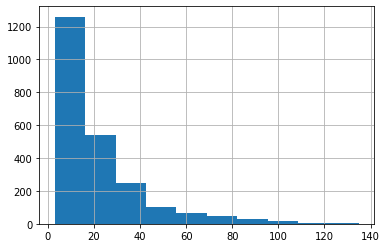

In [73]:
excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR"]).number_of_visits.hist()

### Time range

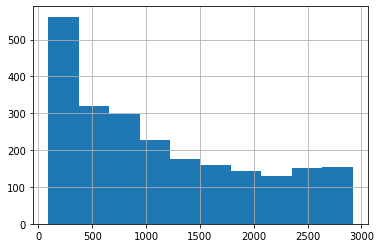

In [74]:
excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR"]).time_range.hist()

## Get only eyes which are naive to the eye clinic itself

In [75]:
inj_date = pd.DataFrame(date_min_max["study_date_dt"]["amin"])

inj_date = inj_date.rename(columns={"amin": "first_oct_date"})
inj_date["PATNR"] = date_min_max[["PATNR"]]
inj_date["laterality"] = date_min_max[["laterality"]]

treatment_naive = pd.merge(excluded_longitudinal_amd_inj[["PATNR", "laterality", "INJECTION_first_date"]], 
         inj_date[["PATNR", "laterality", "first_oct_date"]], 
         left_on=["PATNR", "laterality"], 
         right_on=["PATNR", "laterality"], 
         how="left")

treatment_naive_seq = treatment_naive.drop_duplicates(subset=["PATNR", "laterality"])

In [ ]:
eye_clinic_treatment_naive = pd.to_datetime(treatment_naive_seq["INJECTION_first_date"]) < \
pd.to_datetime(treatment_naive_seq["first_oct_date"])

treatment_naive_seq["oct_after_injections"] = eye_clinic_treatment_naive

### Join with meta table

## Merge Treatment naive patients logging

In [ ]:
excluded_longitudinal_amd_inj = pd.merge(excluded_longitudinal_amd_inj, 
         treatment_naive_seq[["PATNR", "laterality", "oct_after_injections"]], 
         left_on = ["PATNR", "laterality"], 
         right_on=["PATNR", "laterality"], how="left")

### Filter for treatment naive patients

In [ ]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj[excluded_longitudinal_amd_inj.oct_after_injections == False]

In [ ]:
print("Number of patients treatment naive at Eye clinic", 
      excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR"]).shape[0])

#### Drop any duplicate records

In [ ]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR", "laterality", "study_date"])

In [ ]:
excluded_longitudinal_amd_inj

## Check export overlap

In [ ]:
np.unique(excluded_longitudinal_amd_inj.export, return_counts=True)

In [ ]:
patient_bool = excluded_longitudinal_amd_inj.PATNR == 367711
laterality_bool = excluded_longitudinal_amd_inj.laterality == "R"

excluded_longitudinal_amd_inj[patient_bool & laterality_bool][["PATNR", 
                                                               "laterality", 
                                                               "study_date", 
                                                               "export",
                                                               "INJECTION_first_date", 
                                                               "DKEY_first_date"]]

In [ ]:
longitudinal_export_1_pd[longitudinal_export_1_pd.PATNR == 265145]

In [ ]:
longitudinal_export_2_pd[longitudinal_export_2_pd.PATNR == 265145]

In [ ]:
joint_prozeduren_pd[joint_prozeduren_pd.PATNR == 265145]

## Save potential additional time series data

In [ ]:
EXT = "joint_export/longitudinal_tables"
excluded_longitudinal_amd_inj.to_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_longitudinal_naive_information.csv"), 
                                     index=False)

In [ ]:
column_oi = ["PATNR", "birthdate", "DKEY_first_date", "INJECTION_first_date", "time_range", "number_of_visits"]
patient_unique_longitudinal_amd_inj = excluded_longitudinal_amd_inj[column_oi].drop_duplicates(subset=["PATNR"])

patient_unique_longitudinal_amd_inj.to_csv(os.path.join(PROJ_DIR, 
                                                        EXT, 
                                                        "oct_meta_patient_uniquelongitudinal_naive.csv"), 
                                     index=False)